# House Prices - Advanced Regression Techniques

## Table of Contents

- [Project Summary](#Project-Summary)
- [Package Management](#Package-Management)
- [Project Functions](#Project-Functions)
  - [Exploratory Data Analysis Functions](#Exploratory-Data-Analysis-Functions) 
  - [Model Preparation Functions](#Model-Preparation-Functions)
  - [Model Performance Functions](#Model-Performance-Functions) 
- [Model Pipelines](#Model-Pipelines)
  - [Naive Model](#Naive-Model)
  - [Linear Models](#Linear-Models)
    - [General Linear Model](#General-Linear-Model)
  - [Regularization Model Pipelines](#Regularization-Model-Pipelines)
    - [Lasso Model](#Lasso-Model)
    - [Ridge](#Ridge)
    - [Stochastic Gradient Descent](#Stochastic-Gradient-Descent)
    - [Elastic Net](#Elastic-Net)
  - [Support Vector Machines](#Support-Vector-Machines)
  - [Decision Trees](#Decision-Trees)
  - [Random Forest](#Random-Forest)
  - [Gradient Boosting Machine](#Gradient-Boosting-Machine)
  - [Neural Networks](#Neural-Networks)
- [Model Fitting](#Model-Fiting)
- [Model Scoring](#Model-Scoring)
- [Model Peformance](#Model-Performance)

<a id="project-summary"></a>
## Project Summary
#### Author: Michael Curtin
#### Kaggle Competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
#### Docker Image: https://github.com/kaggle/docker-python

<a id="package-management"></a>
## Package Management

In [1]:
# Package Installation
import numpy as np 
import pandas as pd 
import os
import io
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, RFECV

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
import xgboost

from statsmodels.stats.outliers_influence import OLSInfluence # Cook's Distance
from scipy import stats #Confidence Interval
import seaborn as sns

## Load Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
holdout_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
#data.shape
#holdout_data.shape

## Project Functions

### Exploratory Data Analysis Functions

In [4]:
# Code to determine dtypes, missing values, etc...
def analysis(read):
    
    if len(read) > 0:
        print("PROCESS HAS BEEN STARTED\n")

        print("DATA SHAPE")
        print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

        print("EXPLORE MORE ABOUT THE DATA")
        if len(read.select_dtypes("object").columns) > 0:
            print("Object Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("object").columns), "\n", 
                  read.select_dtypes("object").columns.tolist(), "\n")

        if len(read.select_dtypes("integer").columns) > 0:
            print("Integer Variables:", "\n", "VVariables:", 
                  len(read.select_dtypes("integer").columns), "\n", 
                  read.select_dtypes("integer").columns.tolist(), "\n")

        if len(read.select_dtypes("float").columns) > 0:
            print("Float Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("float").columns), "\n", 
                  read.select_dtypes("float").columns.tolist(), "\n")

        if len(read.select_dtypes("bool").columns) > 0:
            print("Bool Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("bool").columns), "\n", 
                  read.select_dtypes("bool").columns.tolist(), "\n")

        print("IS THERE ANY MISSING VALUE")
        print(" \n ", np.where(read.isnull().values.any() == False,"No missing value!", "Data includes missing value!"), "\n")

        buf = io.StringIO()
        read.info(buf=buf)
        check = True
        check = buf.getvalue().split('\n')[-2].split(":")[1].strip()
        print("MEMORY \n", check)

    else:
        print("ERROR!")

    return read

In [5]:
# Inspect Missing Values
def data_cleaning(df):

    print("*********{} *********".format('Inspecting missing values'))
    
    data = df.isna().sum().reset_index().sort_values(by=0, ascending=False)
    clean_data = data[data[0] != 0].shape[0]
    columns = df.shape[1]
    rows = df.shape[0]
    data.columns = ["name", "missing appearences"]
    data["%missing from total"] = data[data["missing appearences"]!=0]["missing appearences"]/rows
    mis_data = data[data["%missing from total"] > 0.5].shape[0]
    #drop_data = np.array(data[data["%missing from total"] > 0.5]["name"])
    
    print("{}/{} total missing data in terms of column shape.".format(clean_data, columns))
    #print("{}/{} columns  will be dropped. name of the drop column is {}".format(mis_data, columns,drop_data))
    
    return data#, drop_data

In [6]:
def histogram_numerical_plots(data):
    data_x = data.copy()
    # Select numerical columns
    num_cols = data_x.select_dtypes(include=['int64', 'float64'])
    # Create subset DataFrame with only numerical values
    data_x_num_cols = data_x[num_cols.columns]
    data_x_num_cols.hist(bins=25, figsize=(40,30))
    plt.show()

In [7]:
# Pearson's R
def corr_matrix(data):
    data_x = data.copy()
    # Select numerical columns
    num_cols = data_x.select_dtypes(include=['int64', 'float64'])
    corr_cols = data_x[num_cols.columns]
    corr_matrix = corr_cols.corr()
    corr_matrix = corr_matrix["SalePrice"].sort_values(ascending=False)
    return corr_matrix

In [8]:
# Univariate Analysis (Compare Train/Test Splits)
def univariate_eda(data, target, var) -> dict:
    if data[var].dtype == 'object':
        data[var] = np.where(data[var].isna(), "NaN", data[var])
        train = data.loc[data['TRAIN_INDEX'] == 1]
        test = data.loc[data['TRAIN_INDEX'] == 0]
        train_grp = train[[var,target]].groupby(var).agg(['count','mean'])
        test_grp = test[[var,target]].groupby(var).agg(['count','mean'])
        grp = pd.merge(train_grp, test_grp, how='outer', left_index=True, right_index=True)
        grp.columns = ['Count_Train', 'SalePrice_Train', 'Count_Test', 'SalePrice_Test']
        print(grp)
        
        count_max = max([max(grp['Count_Train']),max(grp['Count_Test'])])
        sev_max = max([max(grp['SalePrice_Train']),max(grp['SalePrice_Test'])])
        
        df_count = grp[['Count_Train', 'Count_Test']].copy()
        df_sev = grp[['SalePrice_Train', 'SalePrice_Test']].copy()
        
        x = np.arange(len(df_count.index))
        width = 0.3
        multiplier = 0 
        
        fig, ax1 = plt.subplots(constrained_layout=True)
        
        for attribute, measurement in df_count.items():
            offset = width + multiplier
            rects = ax1.bar(x + offset, measurement, width, label=attribute)
            multiplier += 1
            
        ax1.set_title('numerical: ' + var)
        
        ax1.set_ylabel('Counts')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_count.index, rotation=90)
        ax1.legend(loc='upper left')
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('SalePrice')
        ax2.plot(df_sev.index, df_sev['SalePrice_Train'], c='blue', label='SalePrice_Train')
        ax2.plot(df_sev.index, df_sev['SalePrice_Test'], c='darkorange', label='SalePrice_Test')
        ax2.legend(loc='upper right')
    else:
        data_temp = data.copy()
        data_temp['DECILE'] = pd.qcut(data_temp[var], 10, labels=False, duplicates='drop')                   
        temp = data.copy()
        temp['DECILE'] = pd.qcut(temp[var], 10, duplicates='drop')
        data_grp = temp[['DECILE', target]].groupby('DECILE').agg(['count','mean']).reset_index()
        data_grp.columns = [var+'_BOUNDARY', 'Count', 'SalePrice']
        data_grp = data_grp.drop(['Count', 'SalePrice'], axis=1)
        
        train = data_temp.loc[data_temp['TRAIN_INDEX'] == 1]
        test = data_temp.loc[data_temp['TRAIN_INDEX'] == 0]
        
        train_temp = train.copy()
        train_grp = train_temp[['DECILE', target]].groupby('DECILE').agg(['count','mean'])
        train_grp.columns = ['Count_Train', 'SalePrice_Train']
        
        test_temp = test.copy()
        test_grp = test_temp[['DECILE', target]].groupby('DECILE').agg(['count','mean'])
        test_grp.columns = ['Count_Test', 'SalePrice_Test']
        
        grp = pd.merge(data_grp, train_grp, how='outer', left_index=True, right_index=True)
        grp = pd.merge(grp, test_grp, how='outer', left_index=True, right_index=True)
        
        df_count = grp[['Count_Train', 'Count_Test']].copy()
        df_sev = grp[['SalePrice_Train', 'SalePrice_Test']].copy()
        
        x = np.arange(len(df_count.index))
        width = 0.3
        multiplier = 0
        
        fig, ax1 = plt.subplots(constrained_layout=True)
        
        for attribute, measurement in df_count.items():
            offset = width * multiplier
            rects = ax1.bar(x + offset, measurement, width, label=attribute)
            multiplier +=1
            
        ax1.set_title('numerical: ' + var)
        
        ax1.set_ylabel('Counts')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_count.index, rotation=90)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('SalePrice')
        ax2.plot(df_sev.index, df_sev['SalePrice_Train'], label='SalePrice_Train')
        ax2.plot(df_sev.index, df_sev['SalePrice_Test'], label='SalePrice_Test')
        ax2.legend(loc='upper right')
        return 

def check_cardinality(data):
    # Select columns of object type
    object_columns = data.select_dtypes(include=['object']).columns
    
    # Dictionary to store cardinality for each column
    cardinality_dict = {}
    
    # Iterate over object columns and calculate cardinality
    for column in object_columns:
        cardinality = data[column].nunique()  # Count unique values
        cardinality_dict[column] = cardinality
    
    # Sort cardinality_dict by values (cardinality) in descending order
    cardinality_dict_sorted = {k: v for k, v in sorted(cardinality_dict.items(), key=lambda item: item[1], reverse=True)}
    return cardinality_dict_sorted

### Model Preparation Functions

In [9]:
def split_data(df, test_size=0.25, random_state=None):
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)
    train_data['TRAIN_INDEX'] = 1
    test_data['TRAIN_INDEX'] = 0
    train_test_data = pd.concat([train_data, test_data], ignore_index=True)
    print(f"Train data size: {train_data.shape}")
    print(f"Test data size: {test_data.shape}")
    print(f"Train/Test data size: {train_test_data.shape}")
    return train_data, test_data, train_test_data

### Modeling Performance Functions

In [34]:
def lift_chart(data, pred, act, model_type):
    data['Prediction_Decile'] = pd.qcut(data[pred], 20, labels=False, duplicates='drop')
    lift_chart_prediction = data.groupby('Prediction_Decile')[pred].mean().reset_index()
    lift_chart_actual = data.groupby('Prediction_Decile')[act].mean().reset_index()
    
    plt.figure(figsize=(10, 6))  # Set the figure size correctly here
    plt.plot(lift_chart_prediction['Prediction_Decile'], lift_chart_prediction[pred], label='Predicted', color='red')
    plt.plot(lift_chart_actual['Prediction_Decile'], lift_chart_actual[act], label='Actual', color='black')
    plt.xlabel("Prediction Decile")
    plt.ylabel("Average Cost")  # Adjust ylabel based on your data
    plt.legend(loc="upper right")
    plt.title(f"Model Performance Lift Chart - {model_type}")
    plt.grid(True)
    plt.show()
    return

# Define the main evaluation function
def evaluate_pipelines(pipelines, X_train, y_train, X_test, y_test, model_types):
    results = []
    
    for pipeline, model_type in zip(pipelines, model_types):
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # R^2 score
        r2 = r2_score(y_test, y_pred)
        print(f"{model_type} Model R^2 Score: {r2}")
        
        # Evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mean_error = mean_absolute_error(y_test, y_pred)
        mean_percent_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        print(f"{model_type} Model Evaluation Metrics:")
        print(f"RMSE: {rmse}")
        print(f"Mean Error: {mean_error}")
        print(f"Mean Percent Error: {mean_percent_error}%")
        
        results.append({
            'model_type': model_type,
            'R^2 Score': r2,
            'RMSE': rmse,
            'Mean Error': mean_error,
            'Mean Percent Error': mean_percent_error
        })
        
        # Generate the lift chart
        lift_chart_data = pd.DataFrame({'pred': y_pred, 'act': y_test})
            
    return results

    
def print_model_details(models):
    for i, glm_model in enumerate(models):
        coefficients = glm_model.coef_
        intercept = glm_model.intercept_
        print(f"Model {i+1}:")
        print("Intercept:", intercept)
        print("Coefficients:", coefficients)
        print()  # For separating different models

In [11]:
#  evaluate_actual_prediction_period(lift_chart_data, 'pred', 'act')
def evaluate_actual_prediction_period(data, pred, actual):
    data = data.copy()
    #data['YrSold'] = pd.to_datetime(data['YrSold'], format='%Y')
    
    data_count = data.groupby(data['YrSold'].dt.year)[pred].count().to_frame(name='Count').reset_index()
    data_actual = data.groupby(data['YrSold'].dt.year)[actual].mean().to_frame(name='Actual').reset_index()
    data_prediction = data.groupby(data['YrSold'].dt.year)[pred].mean().to_frame(name='Prediction').reset_index()
    
    data_combined = pd.merge(data_count, data_actual, how='inner', left_on='YrSold', right_on='YrSold')
    data_combined = pd.merge(data_combined, data_prediction, how='inner', left_on='YrSold', right_on='YrSold')
    data_combined.set_index('YrSold', inplace=True)
    
    df_count = data_combined[['Count']].copy()
    df_cost = data_combined[['Actual', 'Prediction']].copy()
    
    x = np.arange(len(df_count.index))
    width = 0.3
    multiplier = 0
    
    fig, ax1 = plt.subplots(constrained_layout=True)
    
    for attribute, measurement in df_count.items():
        offset = width * multiplier
        rects = ax1.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1
    
    ax1.set_title("SalePrice Actual vs. Predicted over YrSold")
    ax1.set_ylabel('Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_count.index, rotation=90)
    ax1.legend(loc='upper left')
    ax1.set_ylim(0, 1000000)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("SalePrice")
    ax2.plot(x, df_cost['Actual'], label='Actual', color='black', marker='o')
    ax2.plot(x, df_cost['Prediction'], label='Prediction', color='red', marker='s')
    ax2.legend(loc='upper right')
    
    plt.show()

In [12]:
# Understanding Outliers

## Cook's Distance

## Leverage

In [13]:
# Variable Correlation Analysis

## T-Testing

## Chi-Square Test

from scipy.stats import chi2_contingency

def chi_square_test(df, col1, col2):
    """
    Perform chi-square test of independence between two categorical variables in a DataFrame.

    Parameters:
    df (DataFrame): Pandas DataFrame containing the categorical variables.
    col1 (str): Name of the first categorical column.
    col2 (str): Name of the second categorical column.

    Returns:
    chi2_stat (float): The test statistic of the chi-square test.
    p_val (float): The p-value of the test.
    dof (int): Degrees of freedom.
    contingency_table (DataFrame): The contingency table showing the observed frequencies.
    """

    # Create contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Perform chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    return chi2_stat, p_val, dof, contingency_table

## P-Value Testing

## One-Way Analysis

## VIF Calculations

## Correlation Matrix

## Principal Component Analysis (PCA)

## 


In [14]:
# Execute Analysis, Data Cleaning Functions

# Create Train/Test/Holdout Dataframes
train_data, test_data, train_test_data = split_data(df, random_state=42)

output = analysis(train_data)
missing = data_cleaning(train_data)
missing_data = data_cleaning(train_data)
missing_data.head()

Train data size: (1095, 82)
Test data size: (365, 82)
Train/Test data size: (1460, 82)
PROCESS HAS BEEN STARTED

DATA SHAPE
Observation: 1095 Column: 82 

EXPLORE MORE ABOUT THE DATA
Object Variables: 
 Variables: 43 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

Integer Variables: 
 VVariables: 36 
 ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2

name  missing appearences  %missing from total
72       PoolQC                 1089             0.994521
74  MiscFeature                 1052             0.960731
6         Alley                 1025             0.936073
73        Fence                  877             0.800913
25   MasVnrType                  639             0.583562

### Start Modeling Process 

### Target Variable Analysis (SalePrice)

In [15]:
train_data['SalePrice'].describe()
#train_data.info() - No Missing SalePrice

count      1095.000000
mean     181712.286758
std       77955.082565
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      215000.000000
max      745000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


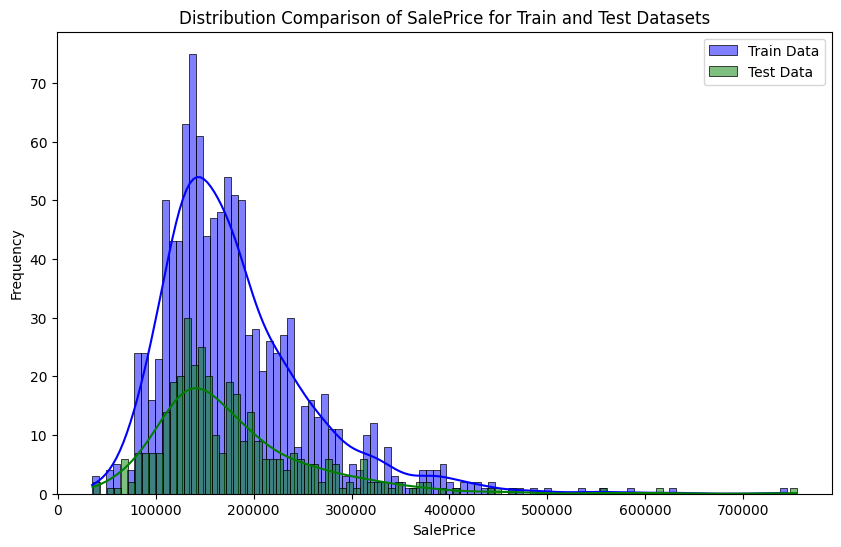

In [16]:
# Plotting SalePrice Distributions for Train/Test Data
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, color='blue', alpha=0.5, bins=100, label='Train Data')
sns.histplot(test_data['SalePrice'], kde=True, color='green', alpha=0.5, bins=100, label='Test Data')

# Customizing the plot
plt.title('Distribution Comparison of SalePrice for Train and Test Datasets')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Understanding Distribution Shape (Kurtosis Calculation)

In [17]:
# Kurtosis
kurtosis_data_train = train_data['SalePrice']
train_kurtosis_value = kurtosis_data_train.kurtosis()

kurtosis_data_test = test_data['SalePrice']
test_kurtosis_value = kurtosis_data_test.kurtosis()

print(f"Train Kurtosis Value: {train_kurtosis_value}")
print(f"Train Kurtosis Value: {test_kurtosis_value}")

Train Kurtosis Value: 5.558492262294914
Train Kurtosis Value: 8.83342583521772


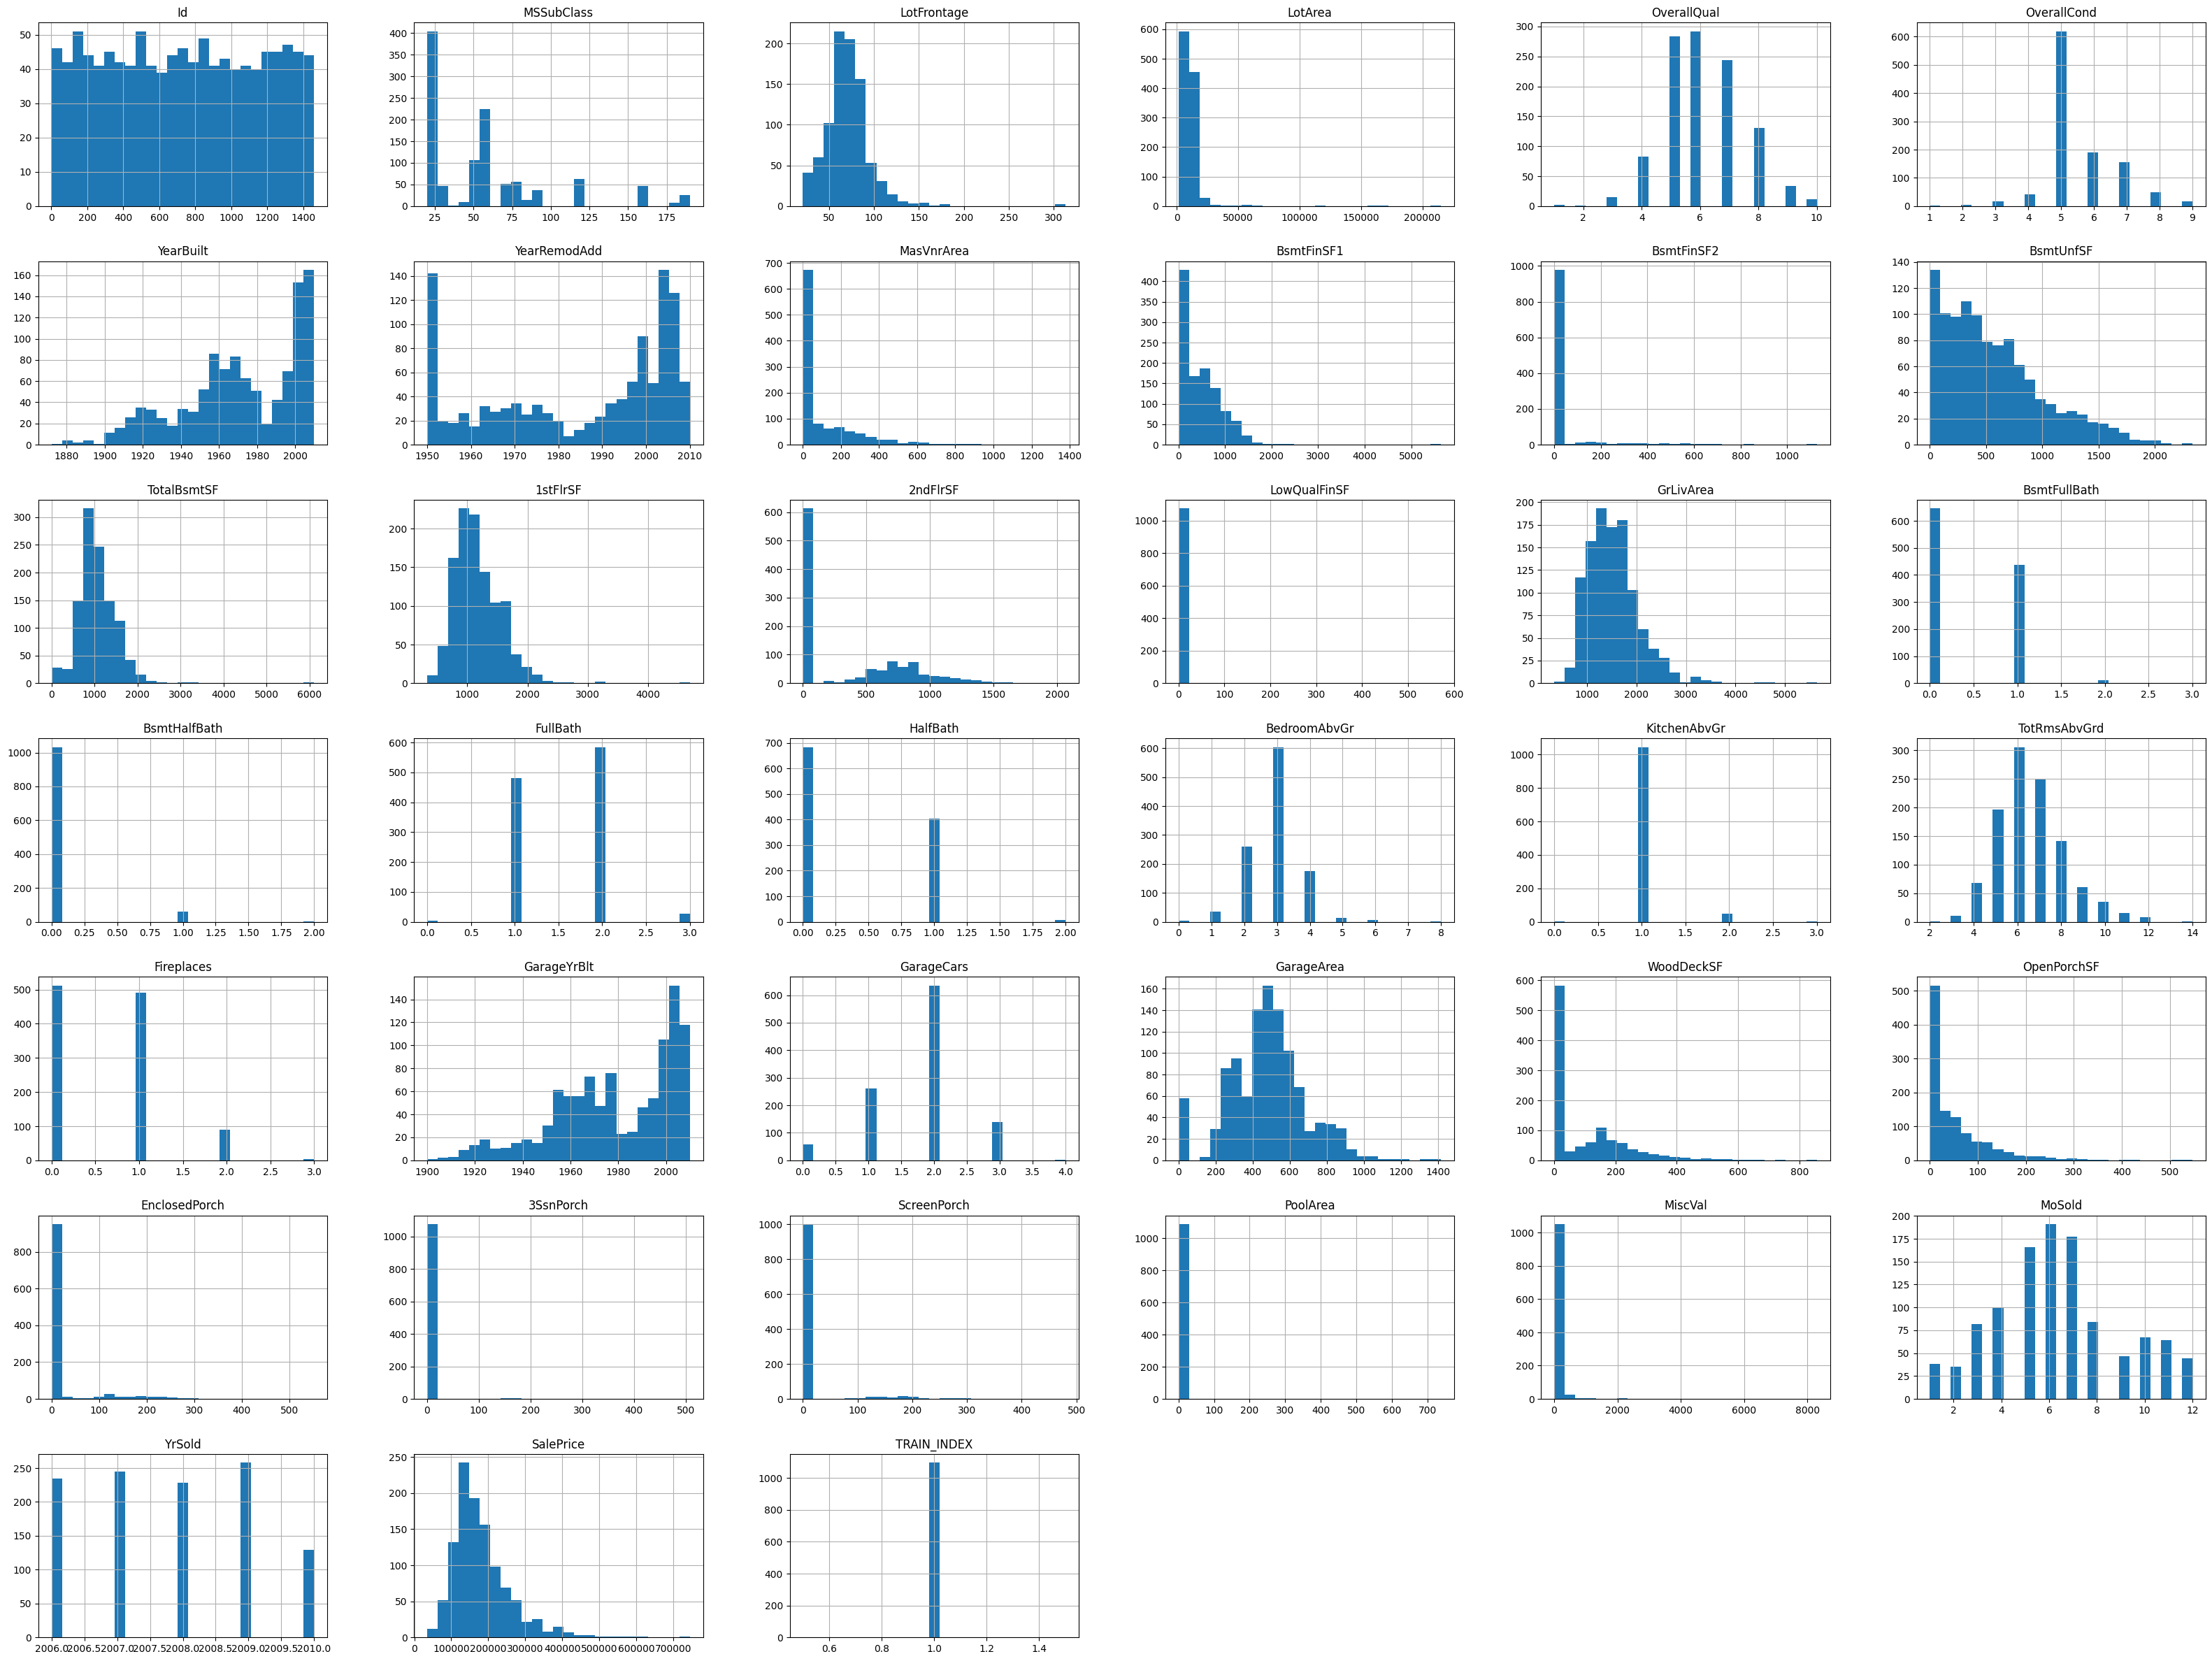

In [18]:
### Exploratory Data Analysis
histogram_numerical_plots(train_data)

In [19]:
### Pearson's R Output
corr_matrix(train_data)

SalePrice        1.000000
OverallQual      0.785016
GrLivArea        0.692972
GarageCars       0.643580
GarageArea       0.621928
TotalBsmtSF      0.593732
1stFlrSF         0.583574
FullBath         0.550914
TotRmsAbvGrd     0.523328
YearBuilt        0.519099
YearRemodAdd     0.512854
GarageYrBlt      0.480037
Fireplaces       0.459994
MasVnrArea       0.459550
BsmtFinSF1       0.359898
WoodDeckSF       0.330551
LotFrontage      0.328260
2ndFlrSF         0.317607
OpenPorchSF      0.288251
HalfBath         0.280946
LotArea          0.265577
BsmtFullBath     0.231760
BsmtUnfSF        0.222568
BedroomAbvGr     0.154896
PoolArea         0.118131
ScreenPorch      0.115839
3SsnPorch        0.054816
MoSold           0.043126
BsmtFinSF2      -0.001716
LowQualFinSF    -0.009295
YrSold          -0.010726
MiscVal         -0.019789
Id              -0.030655
BsmtHalfBath    -0.053061
OverallCond     -0.076693
MSSubClass      -0.089014
EnclosedPorch   -0.144342
KitchenAbvGr    -0.145757
TRAIN_INDEX 

### SalePrice Time Series Analysis

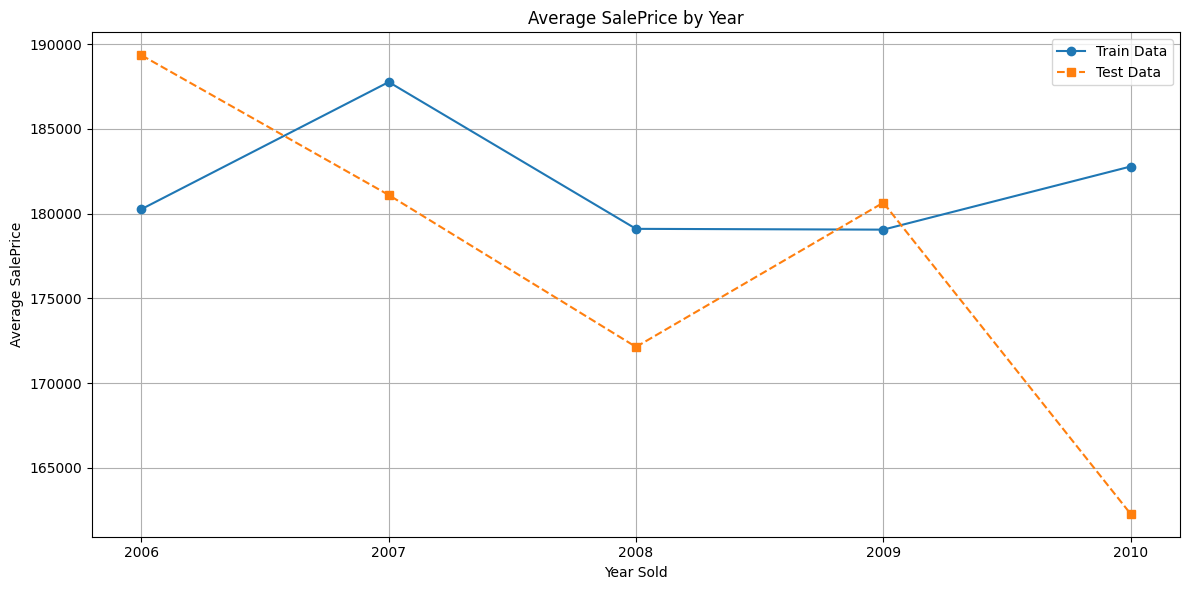

In [20]:
# Group by 'YrSold' and calculate count and mean of 'SalePrice' for both DataFrames
sale_years_train = train_data.groupby('YrSold')['SalePrice'].agg(['count', 'mean'])
sale_years_test = test_data.groupby('YrSold')['SalePrice'].agg(['count', 'mean'])

# Print the results
#print("Sales from Each Year - Train Data:")
#print(sale_years_train)
#print("\nSales from Each Year - Test Data:")
#print(sale_years_test)

# Plotting the line charts for both DataFrames
plt.figure(figsize=(12, 6))

plt.plot(sale_years_train.index, sale_years_train['mean'], marker='o', linestyle='-', label='Train Data')
plt.plot(sale_years_test.index, sale_years_test['mean'], marker='s', linestyle='--', label='Test Data')

plt.title('Average SalePrice by Year')
plt.xlabel('Year Sold')
plt.ylabel('Average SalePrice')
plt.grid(True)
plt.xticks(sale_years_train.index)
plt.legend()
plt.tight_layout()
plt.show()

### Feature Engineering

In [21]:
all_variable_list = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
                 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
                 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
                 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 
                 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']

#all_variable_list = ['LotArea', 'KitchenQual']

In [22]:
check_cardinality(train_data)

{'Neighborhood': 25,
 'Exterior2nd': 16,
 'Exterior1st': 15,
 'Condition1': 9,
 'SaleType': 9,
 'HouseStyle': 8,
 'RoofMatl': 7,
 'Functional': 7,
 'Condition2': 6,
 'RoofStyle': 6,
 'Foundation': 6,
 'BsmtFinType1': 6,
 'BsmtFinType2': 6,
 'Heating': 6,
 'GarageType': 6,
 'SaleCondition': 6,
 'MSZoning': 5,
 'LotConfig': 5,
 'BldgType': 5,
 'ExterCond': 5,
 'HeatingQC': 5,
 'FireplaceQu': 5,
 'GarageQual': 5,
 'GarageCond': 5,
 'LotShape': 4,
 'LandContour': 4,
 'ExterQual': 4,
 'BsmtQual': 4,
 'BsmtCond': 4,
 'BsmtExposure': 4,
 'Electrical': 4,
 'KitchenQual': 4,
 'Fence': 4,
 'MiscFeature': 4,
 'LandSlope': 3,
 'MasVnrType': 3,
 'GarageFinish': 3,
 'PavedDrive': 3,
 'PoolQC': 3,
 'Street': 2,
 'Alley': 2,
 'Utilities': 2,
 'CentralAir': 2}

          Count_Train  SalePrice_Train  Count_Test  SalePrice_Test
MSZoning                                                          
C (all)             4     90450.000000           6    63913.333333
FV                 47    217907.744681          18   203847.222222
RH                 14    129423.857143           2   146500.000000
RL                866    191351.683603         285   189951.547368
RM                164    127128.036585          54   123853.166667
        Count_Train  SalePrice_Train  Count_Test  SalePrice_Test
Street                                                          
Grvl              4    161037.500000           2    68496.500000
Pave           1091    181788.087993         363   179154.267218
       Count_Train  SalePrice_Train  Count_Test  SalePrice_Test
Alley                                                          
Grvl            44    124419.409091           6   106083.333333
NaN           1025    184441.075122         344   180505.424419
Pave           

/tmp/ipykernel_607/2745510080.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(constrained_layout=True)


              Count_Train  SalePrice_Train  Count_Test  SalePrice_Test
BsmtExposure                                                          
Av                    163    212444.797546          58   190339.551724
Gd                     98    245493.948980          36   290889.638889
Mn                     88    197477.784091          26   176922.153846
NaN                    27    105395.074074          11   114180.909091
No                    719    166987.945758         234   161548.311966
              Count_Train  SalePrice_Train  Count_Test  SalePrice_Test
BsmtFinType1                                                          
ALQ                   170    160860.147059          50   163997.000000
BLQ                   112    150525.446429          36   146283.638889
GLQ                   313    234245.824281         105   238895.161905
LwQ                    57    149730.701754          17   158967.647059
NaN                    27    105395.074074          10   106349.000000
Rec   

/tmp/ipykernel_607/2745510080.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grp = temp[['DECILE', target]].groupby('DECILE').agg(['count','mean']).reset_index()
/tmp/ipykernel_607/2745510080.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grp = temp[['DECILE', target]].groupby('DECILE').agg(['count','mean']).reset_index()
/tmp/ipykernel_607/2745510080.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warnin

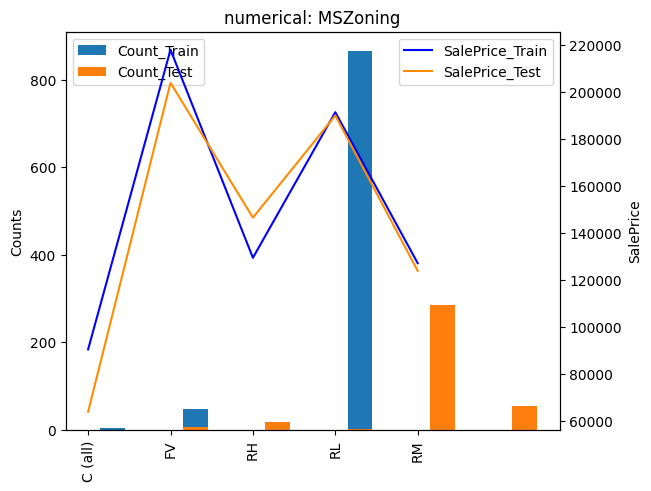

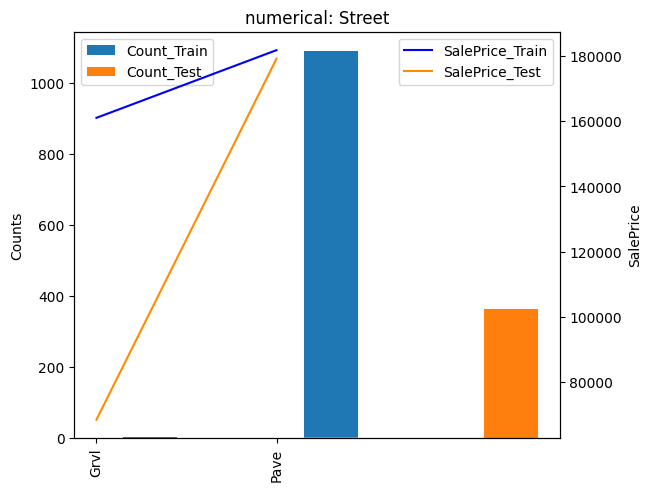

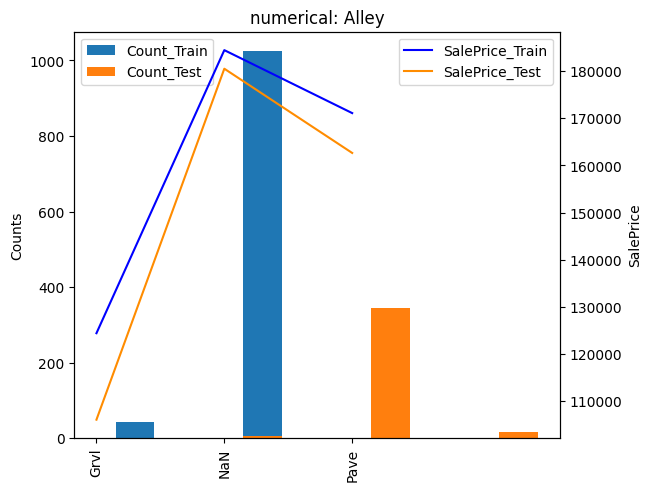

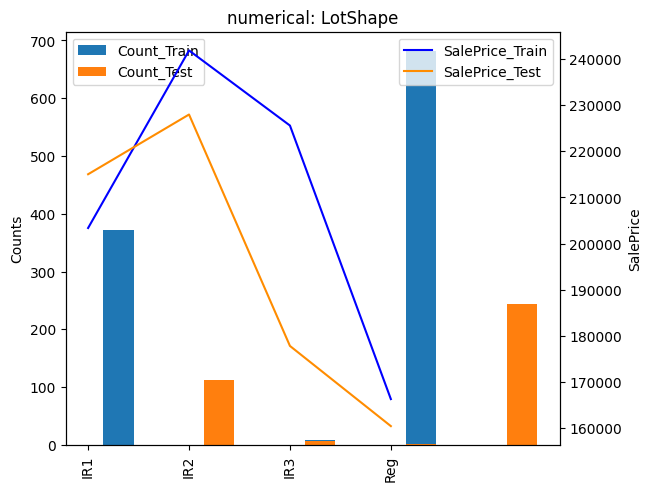

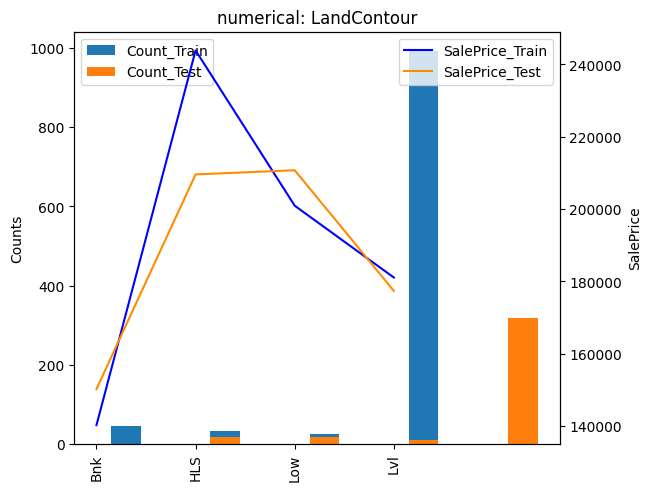

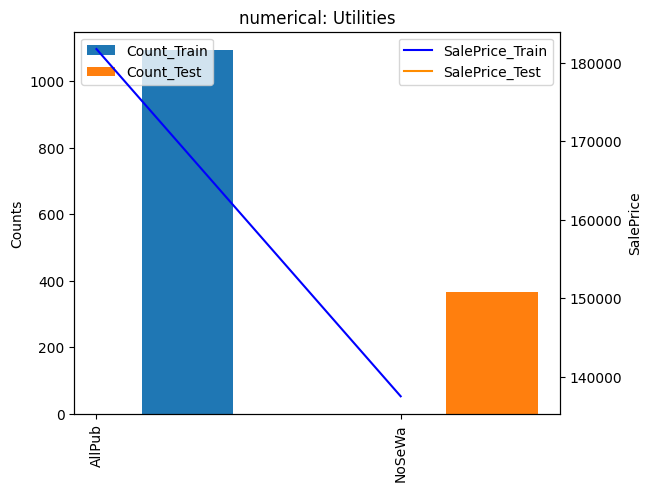

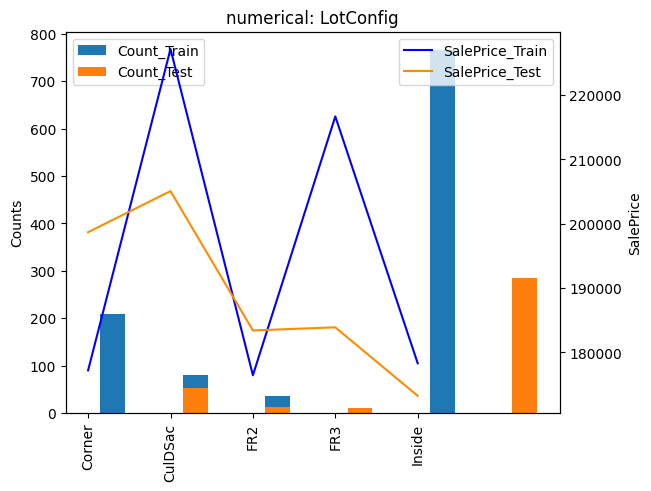

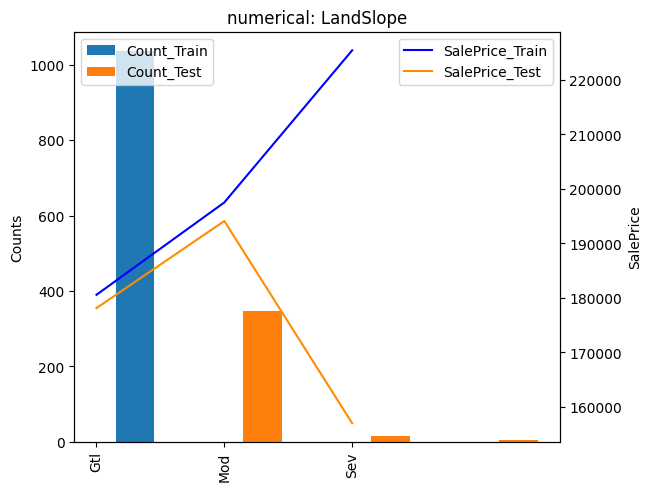

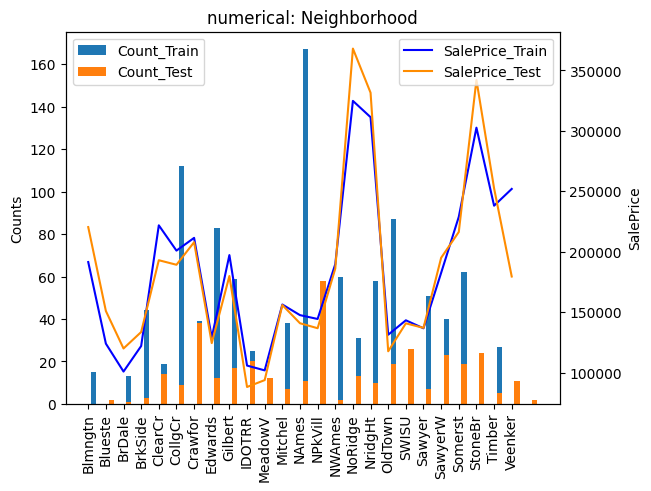

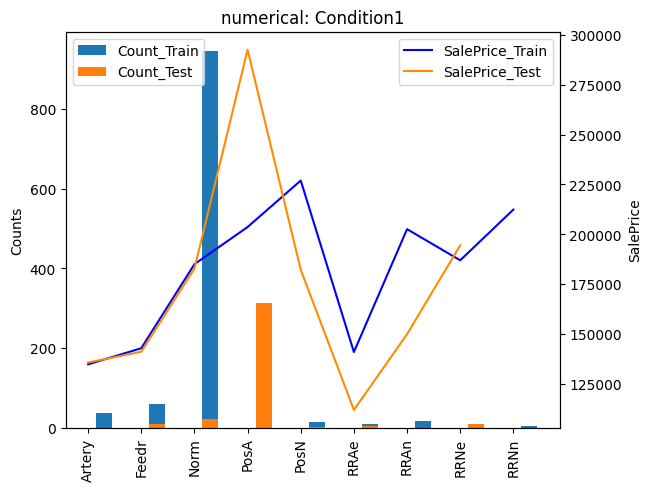

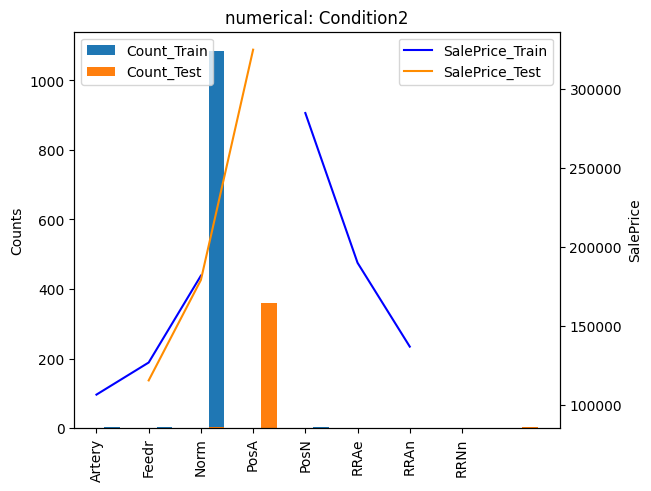

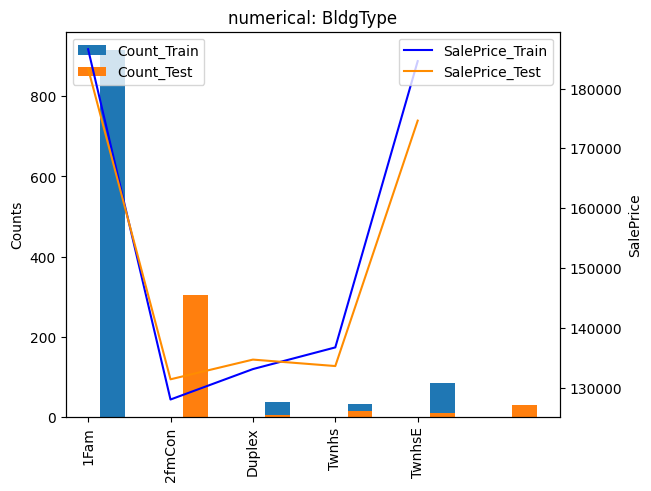

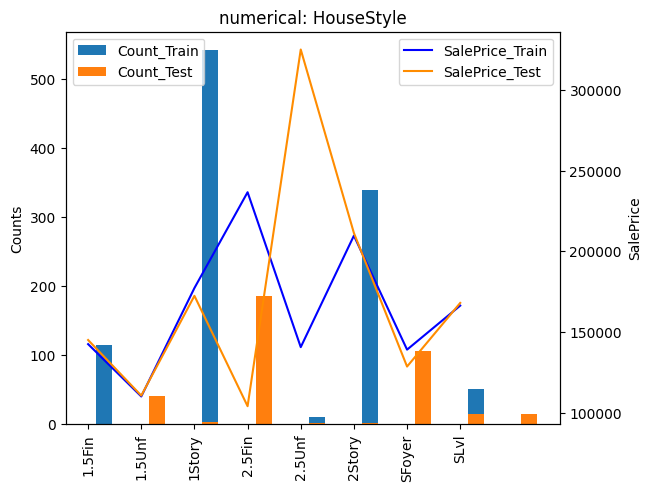

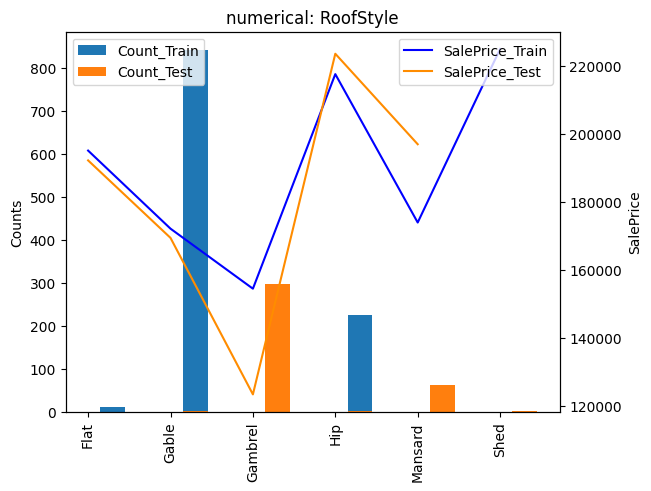

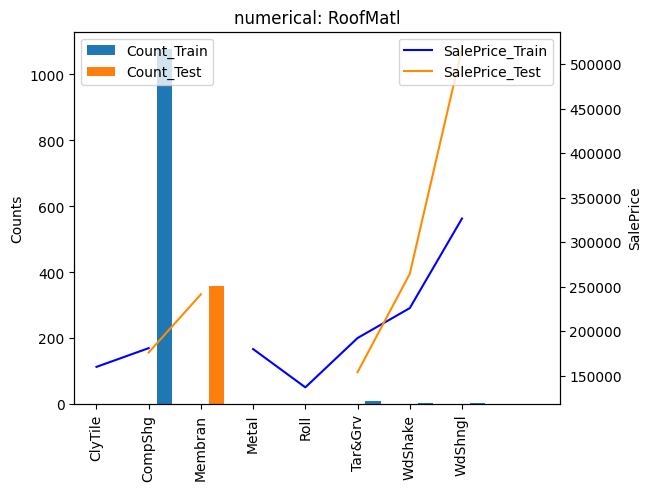

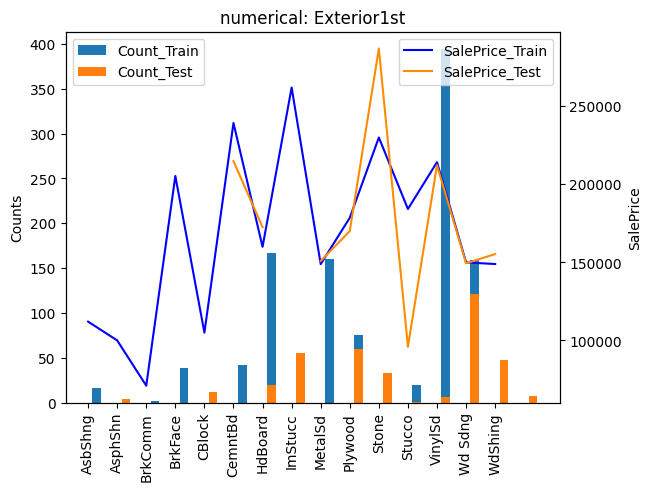

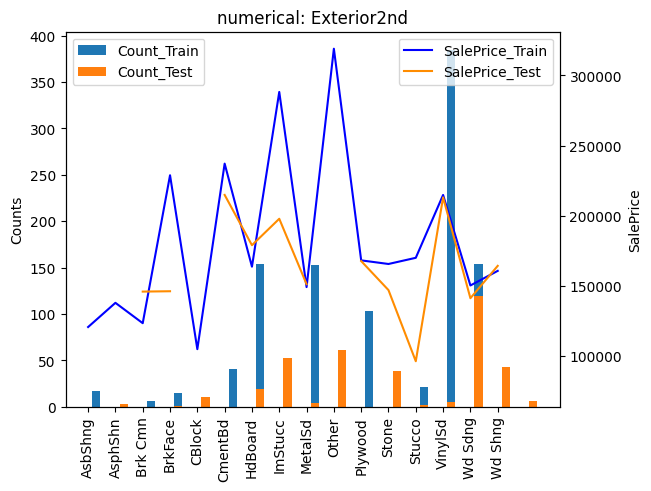

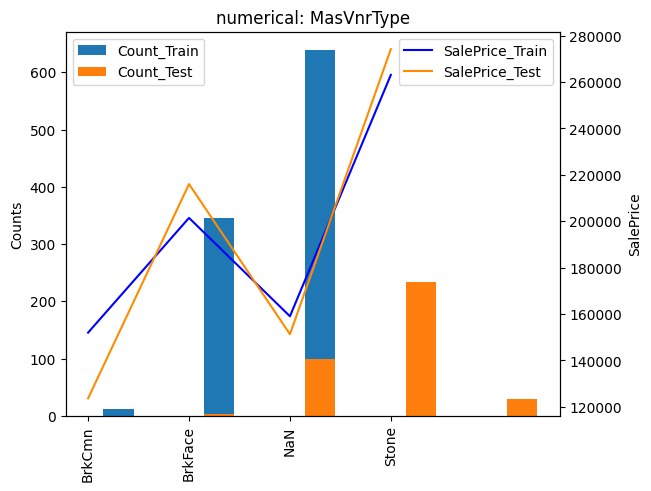

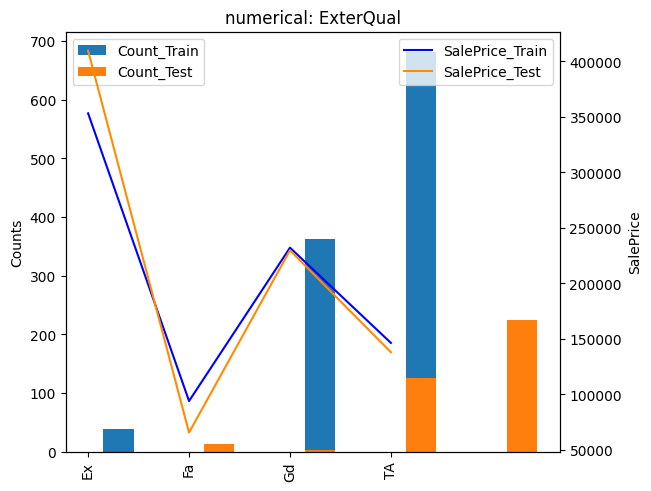

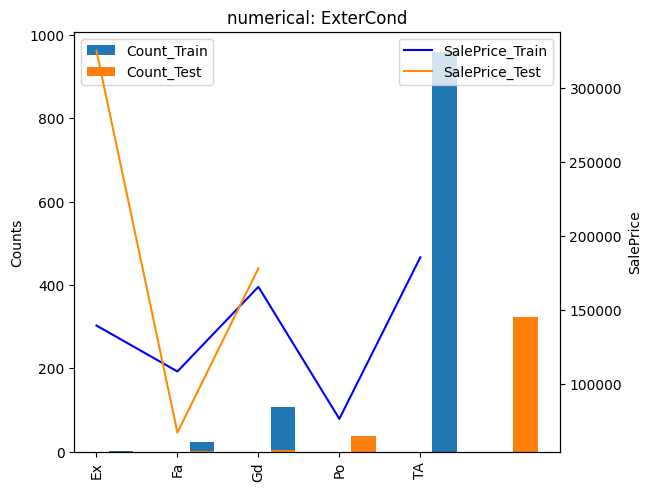

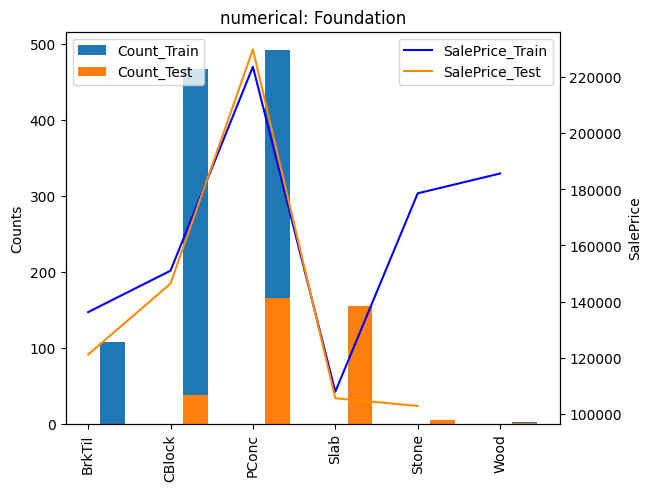

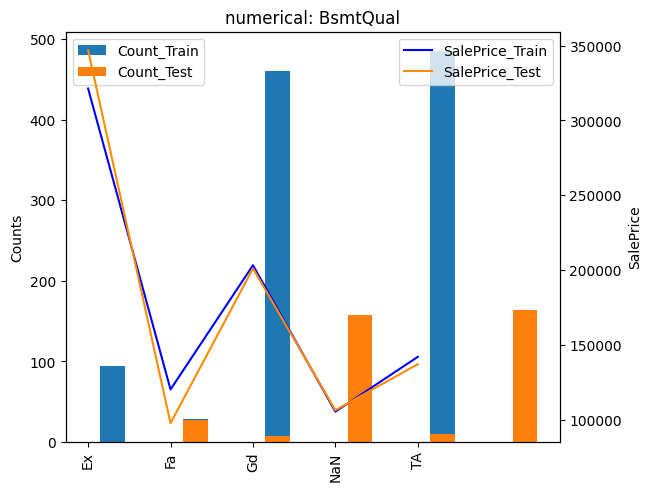

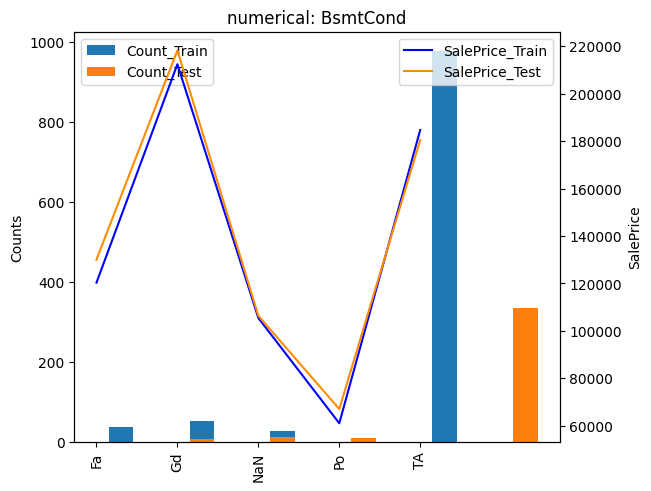

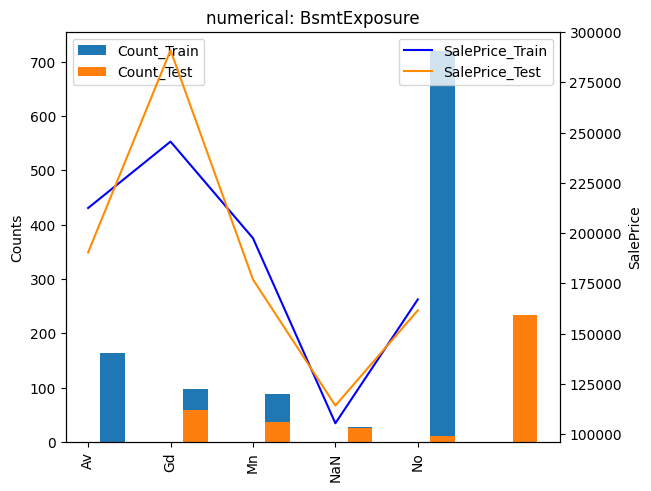

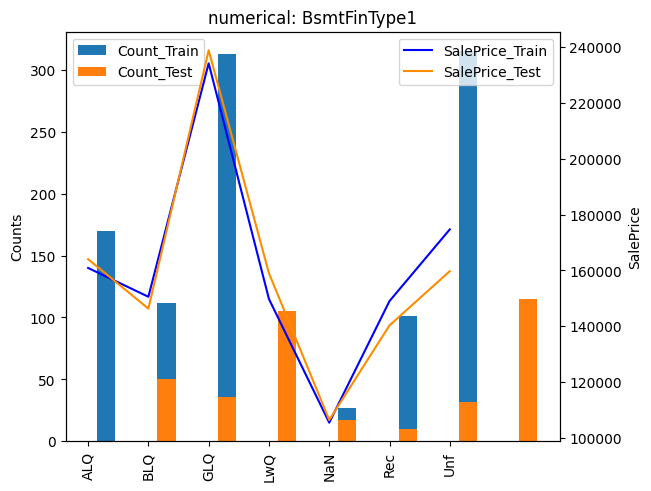

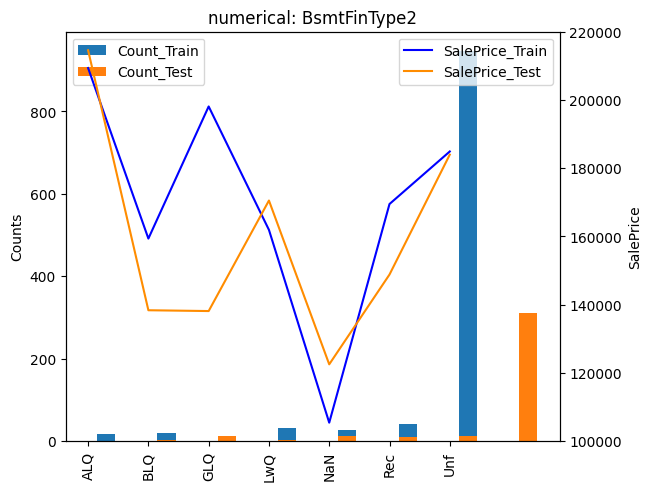

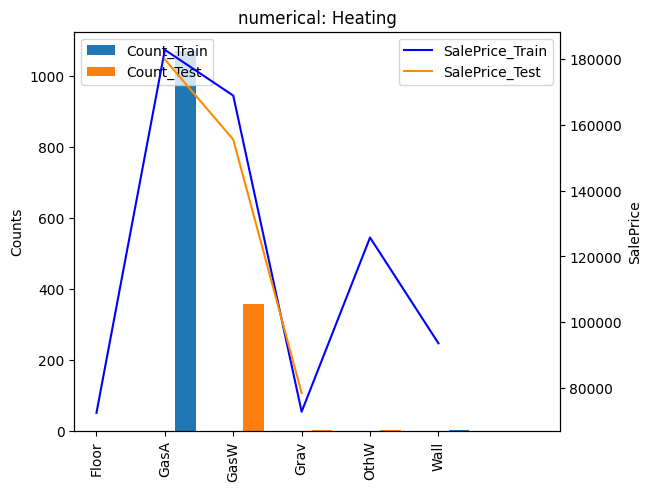

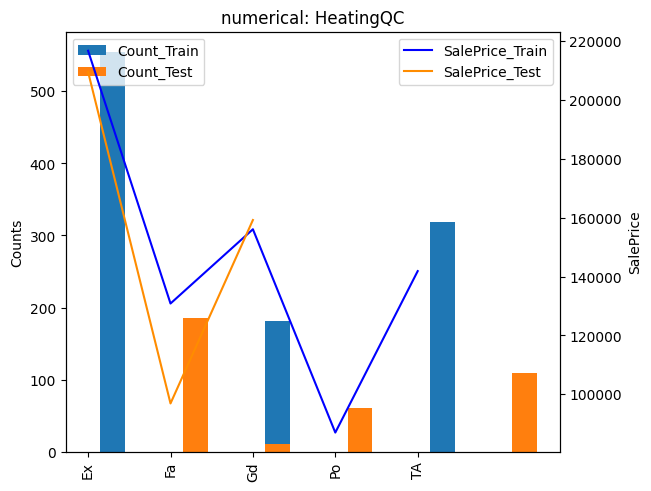

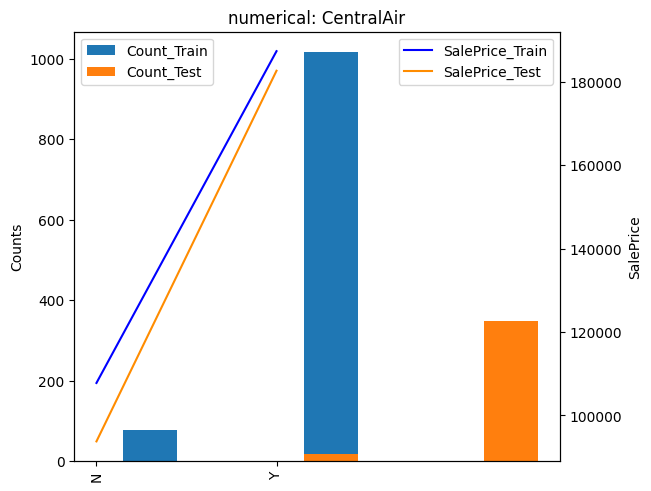

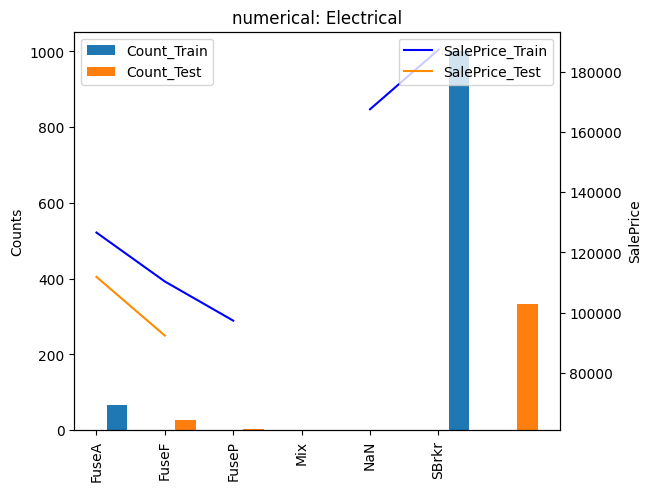

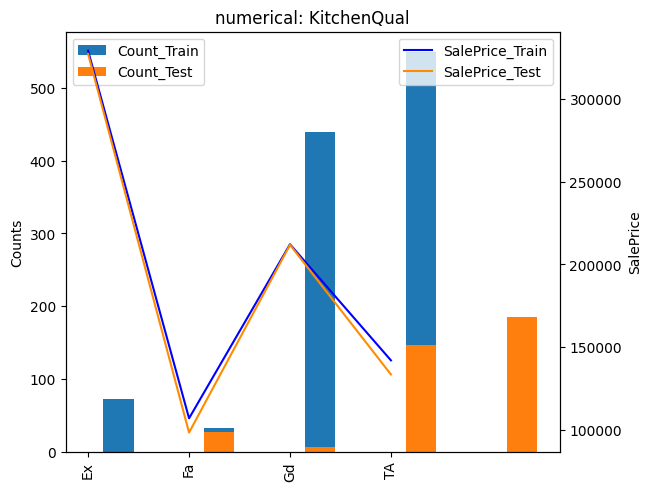

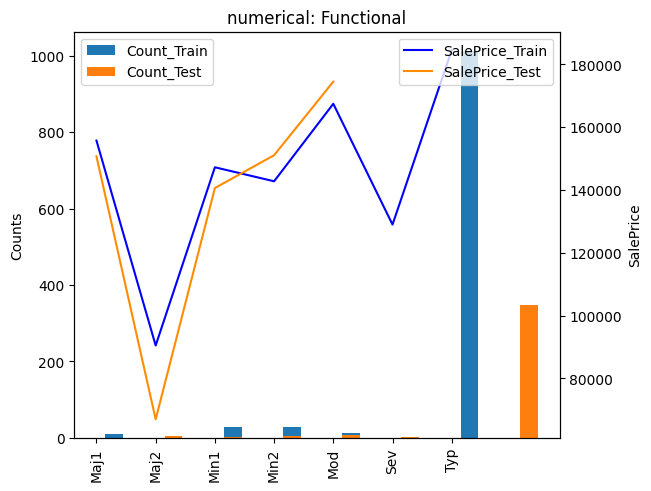

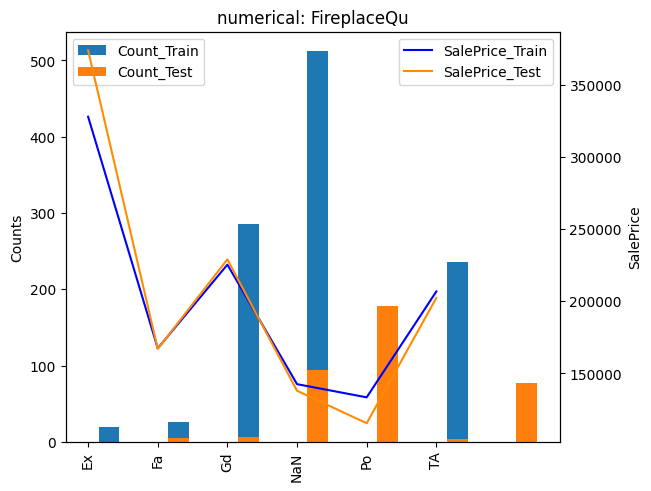

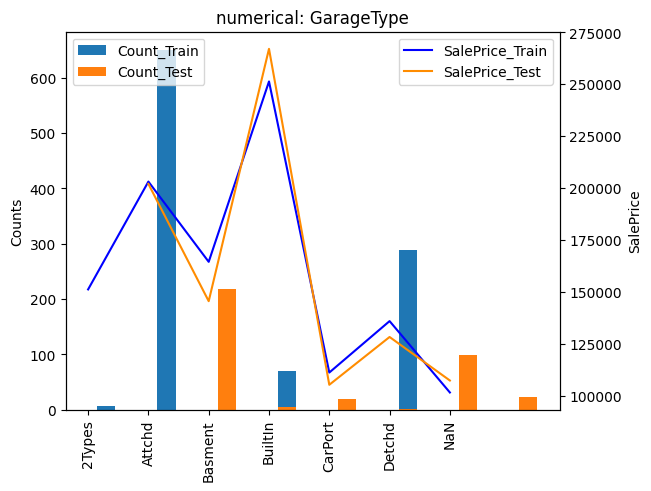

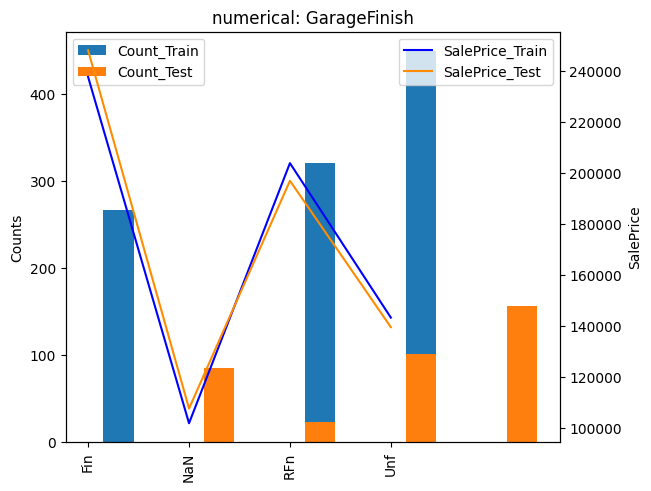

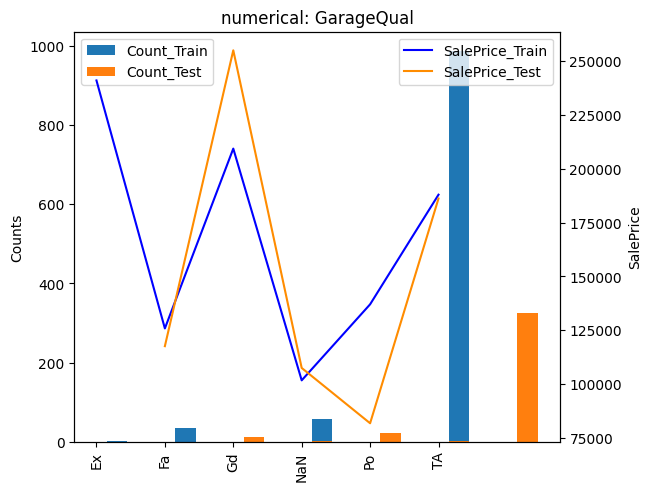

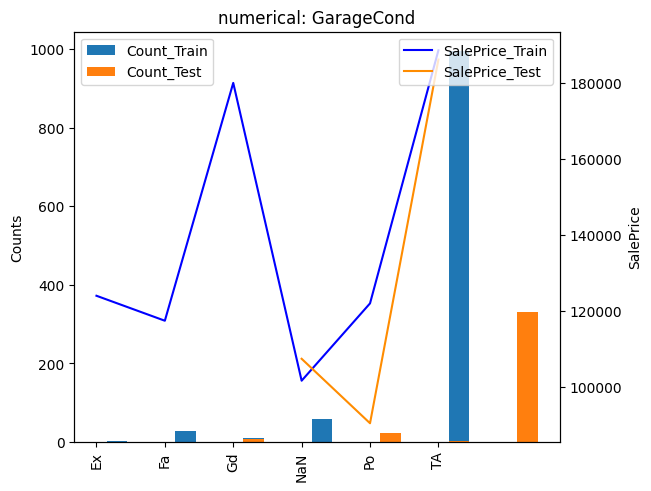

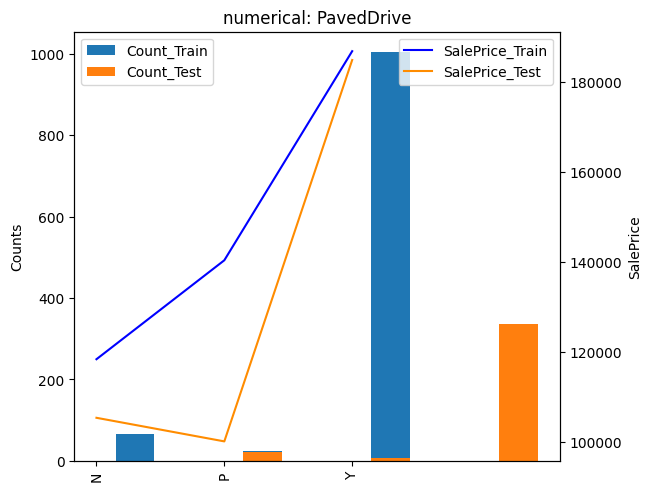

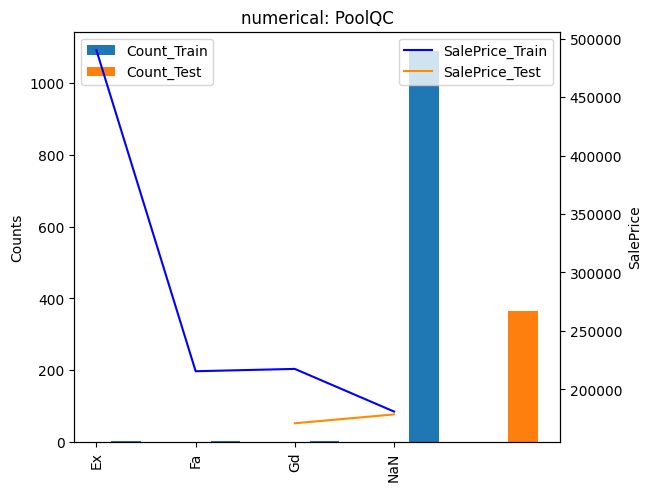

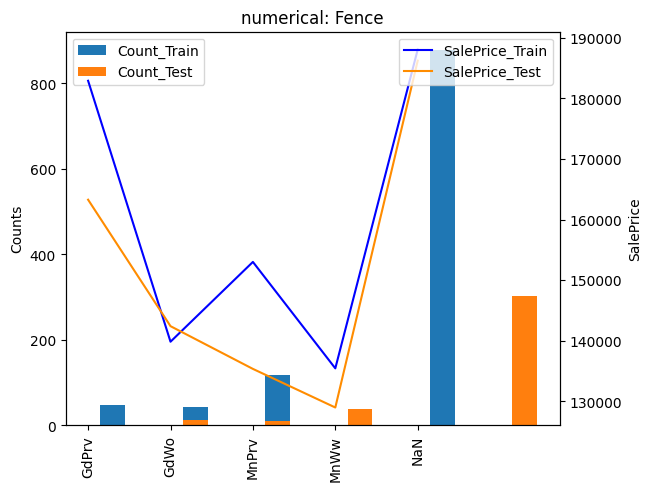

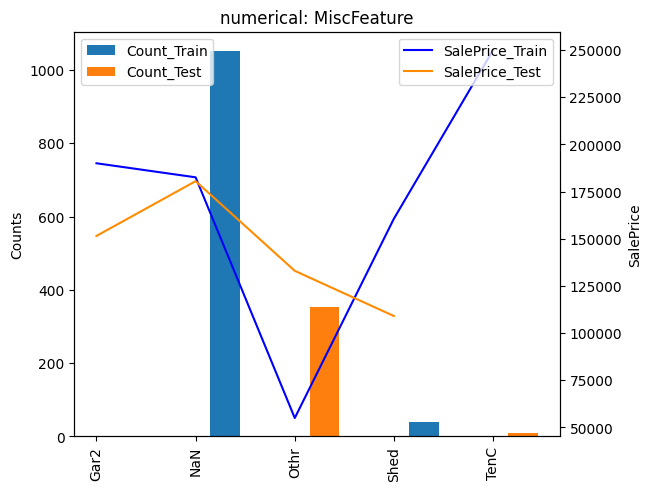

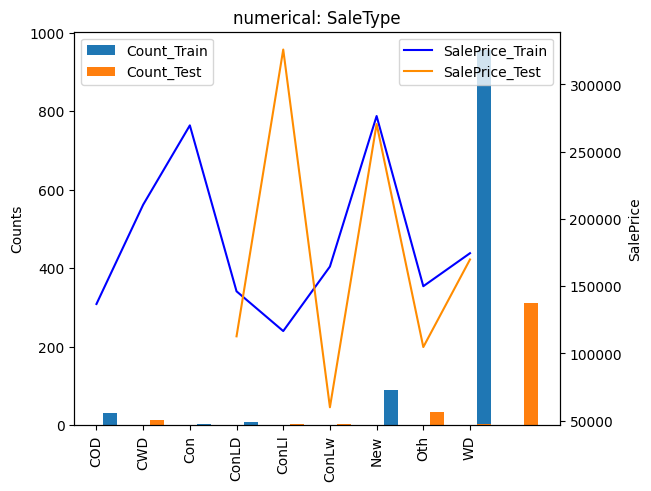

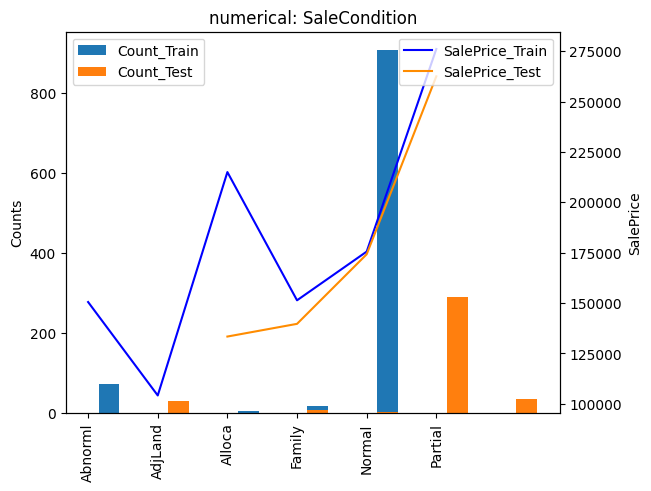

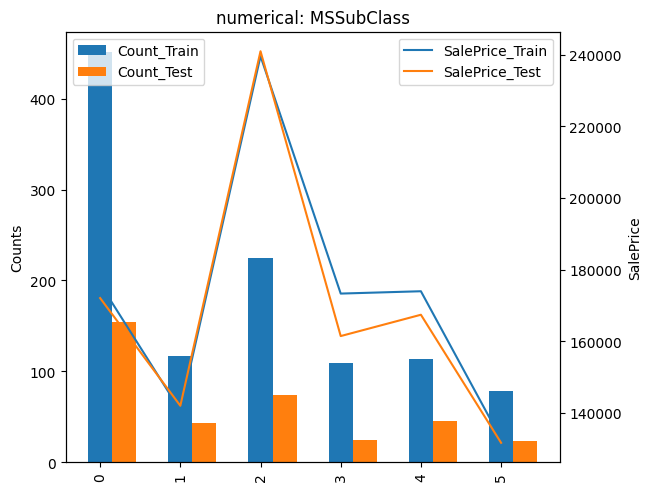

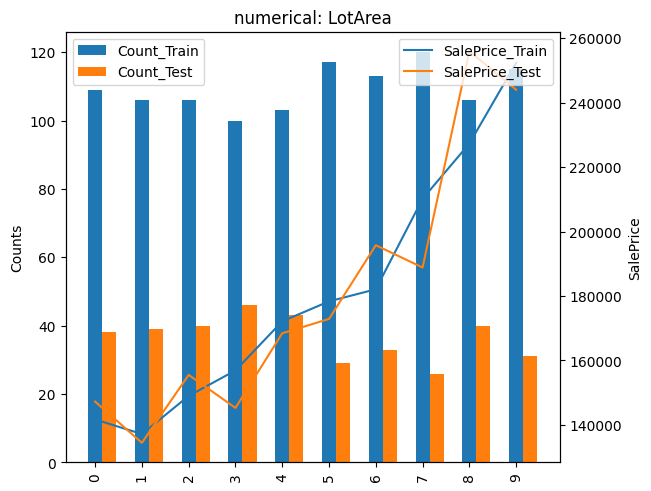

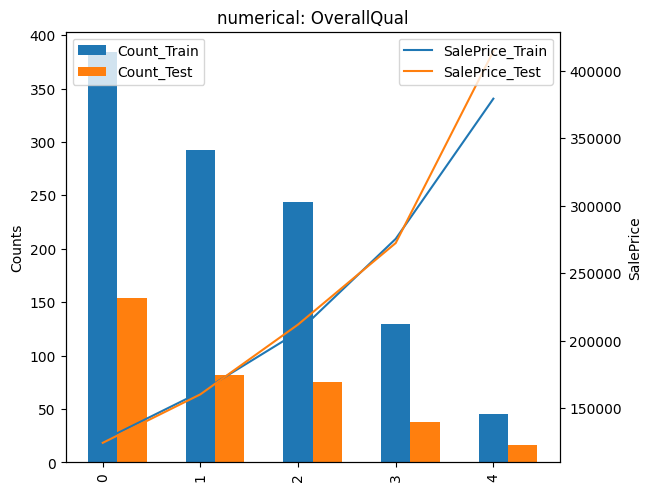

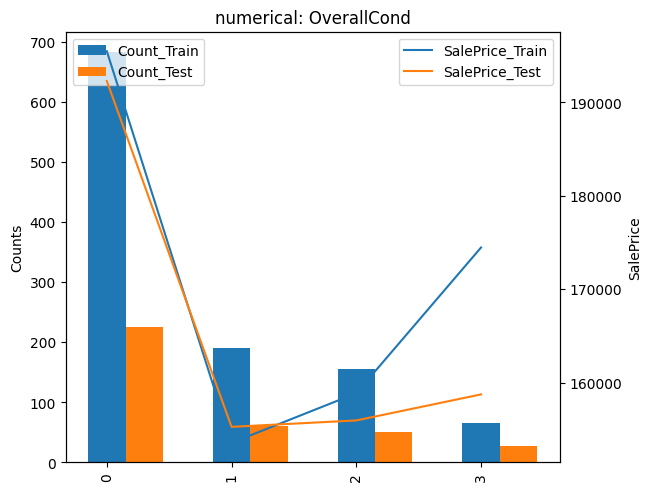

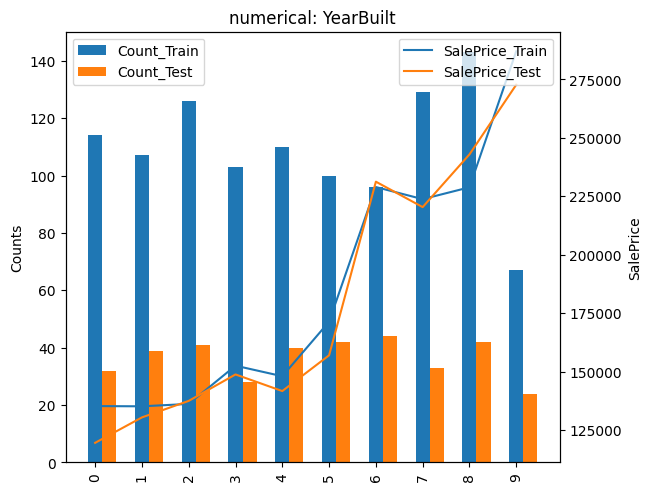

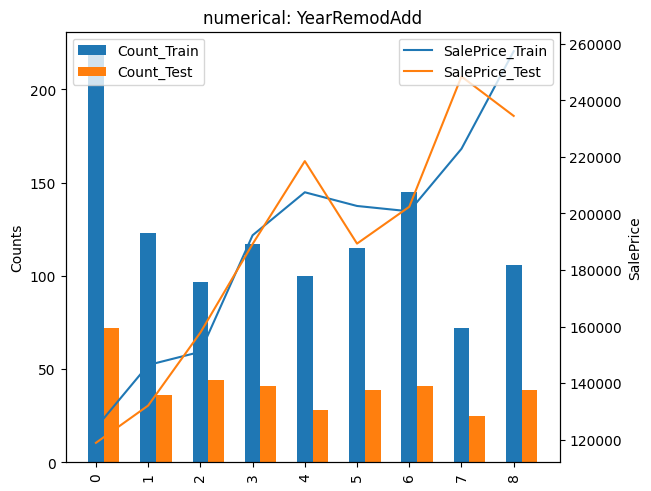

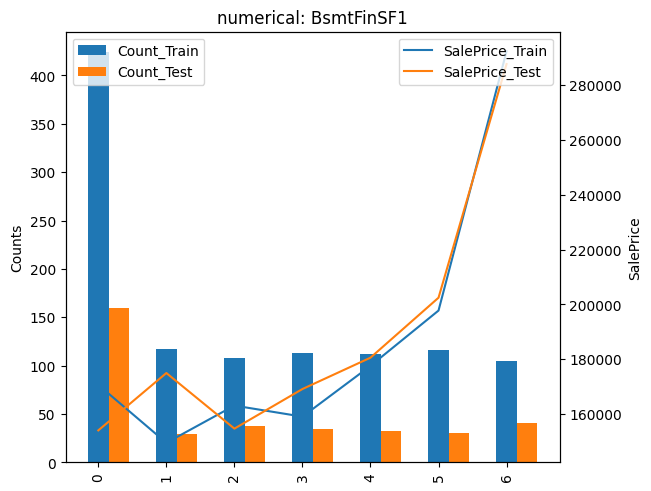

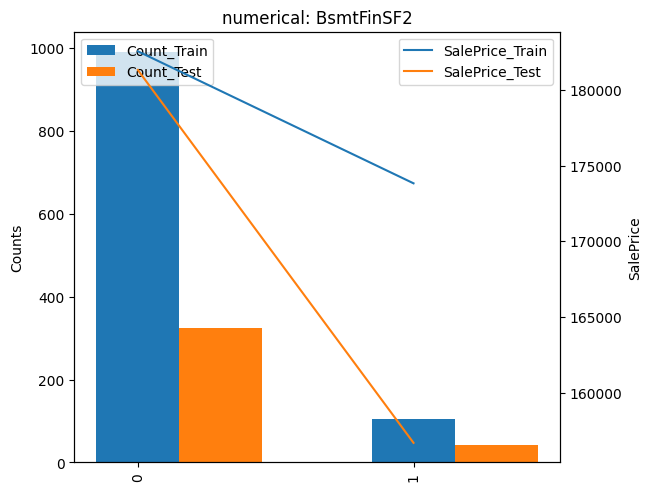

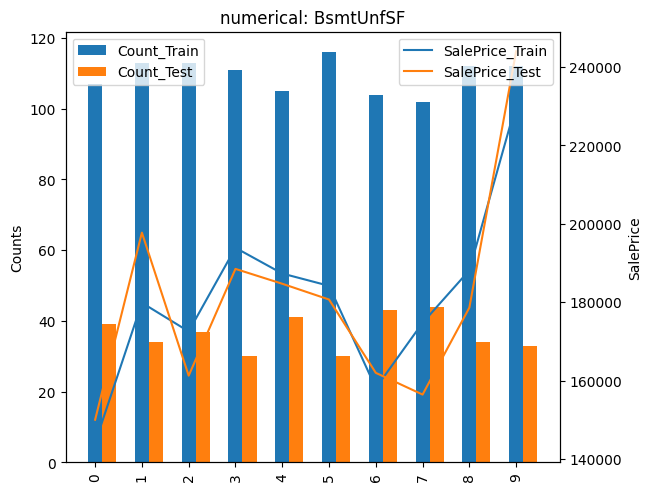

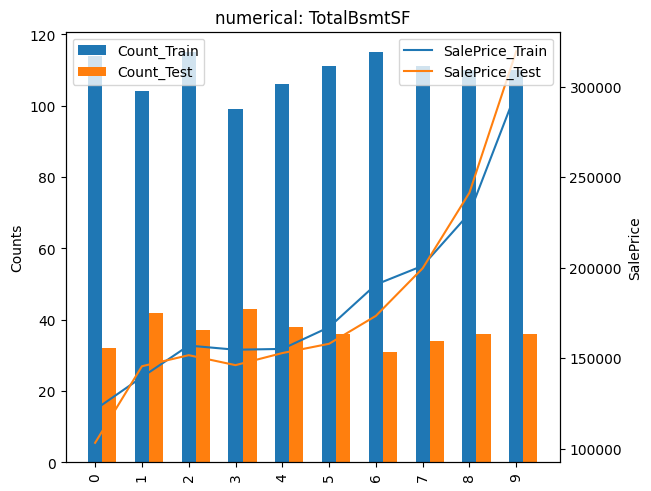

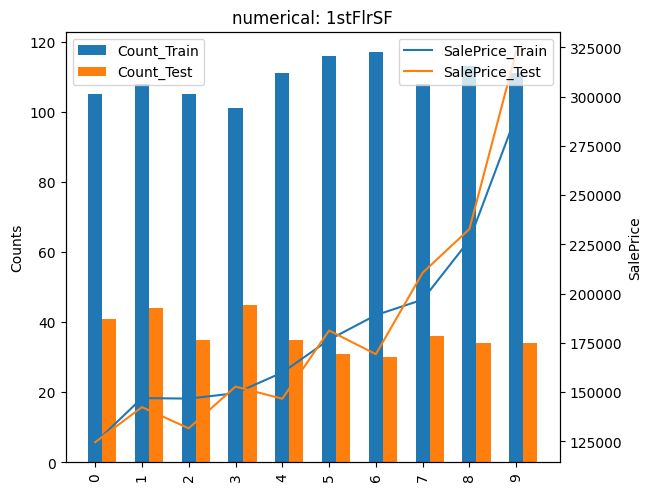

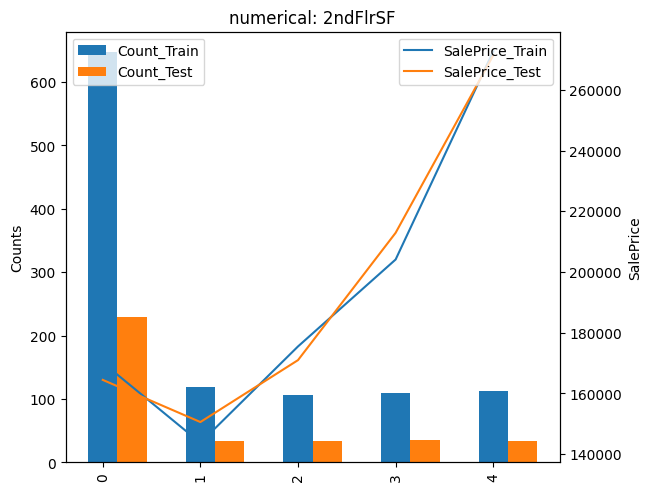

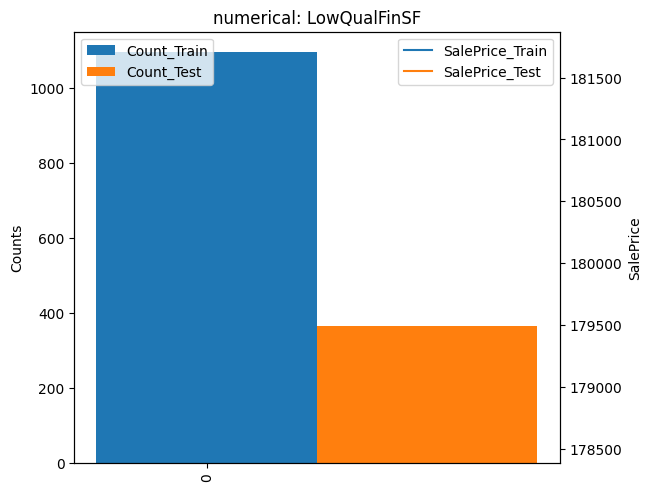

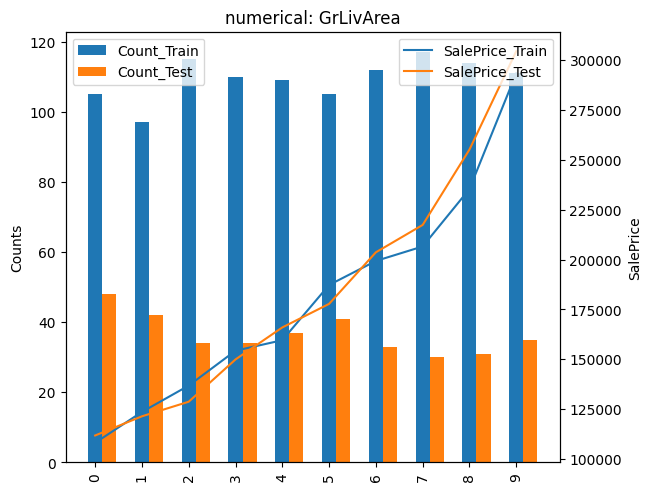

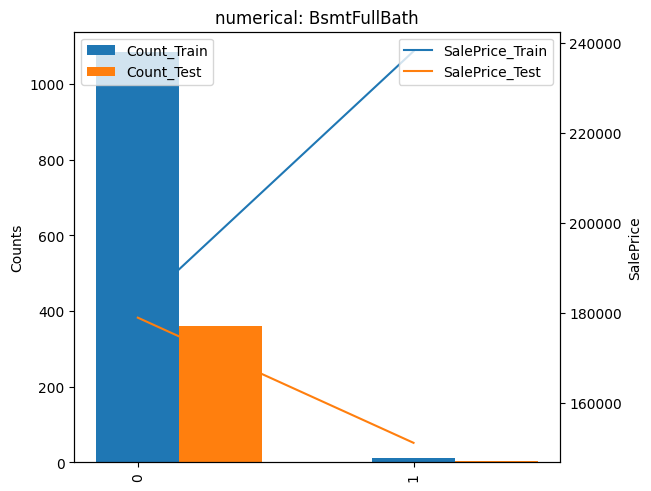

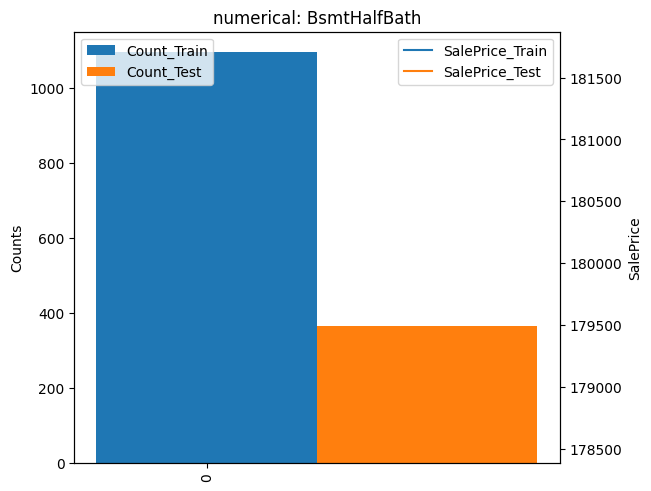

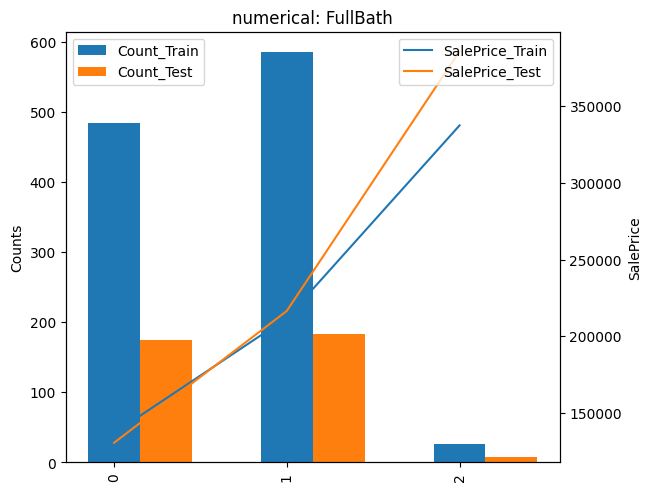

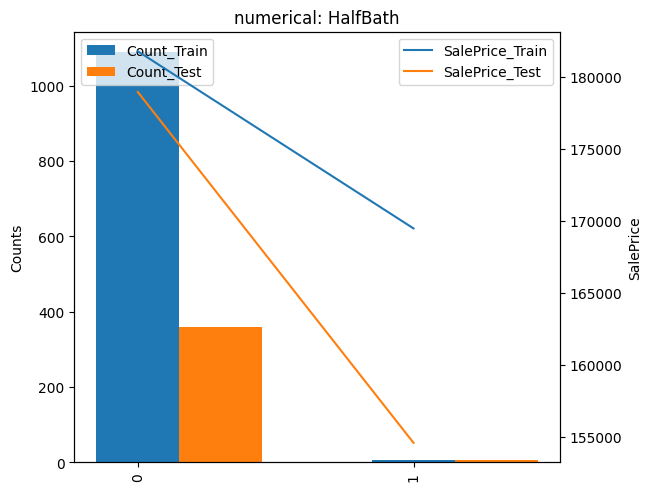

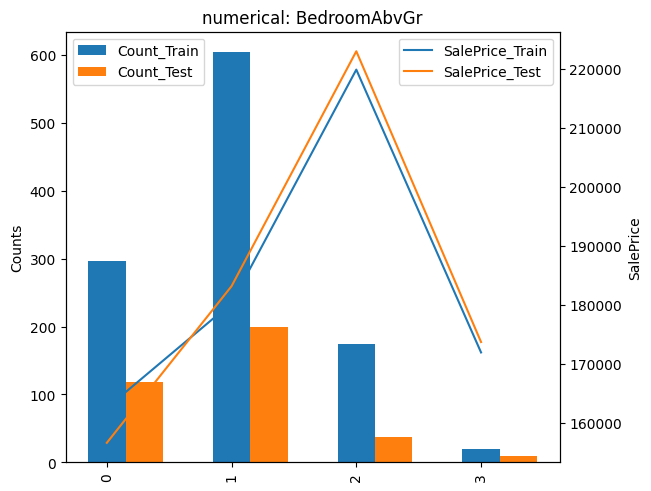

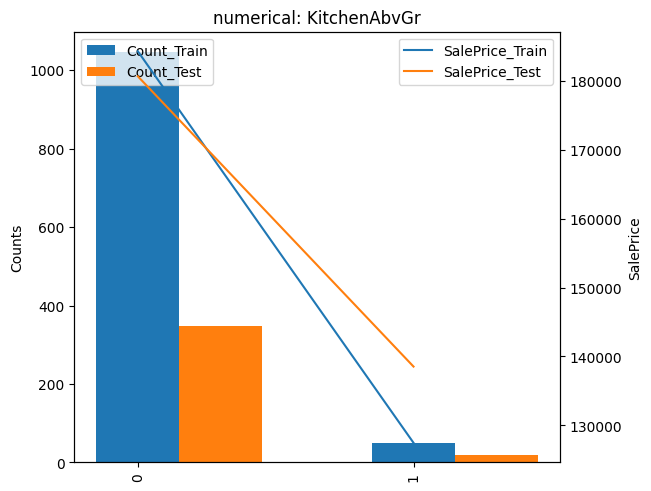

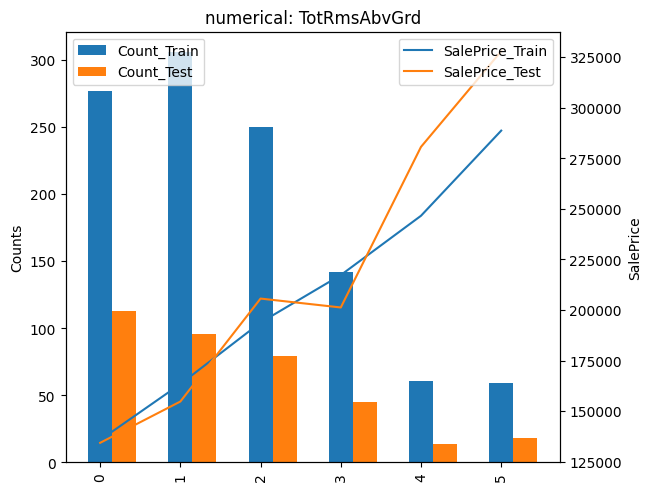

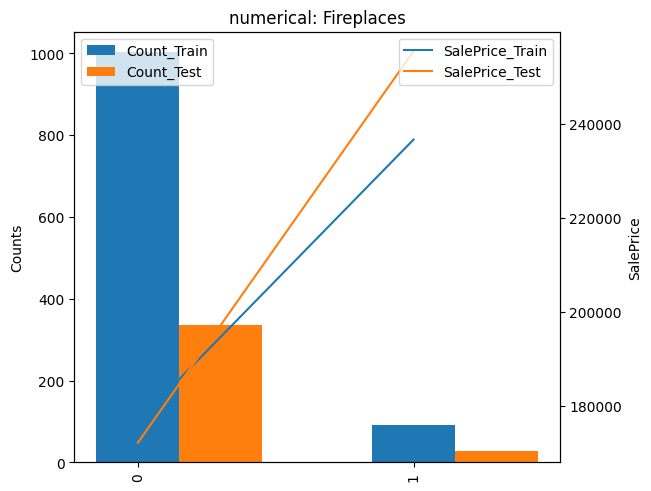

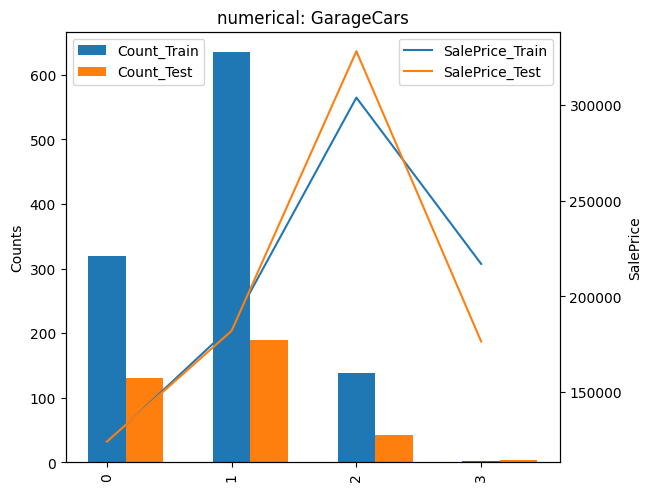

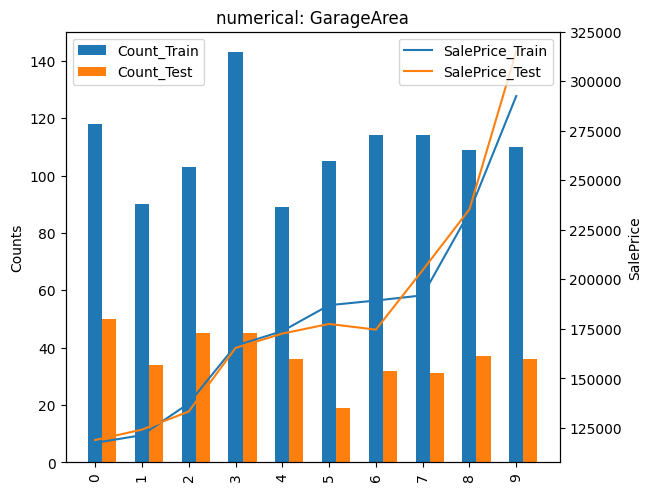

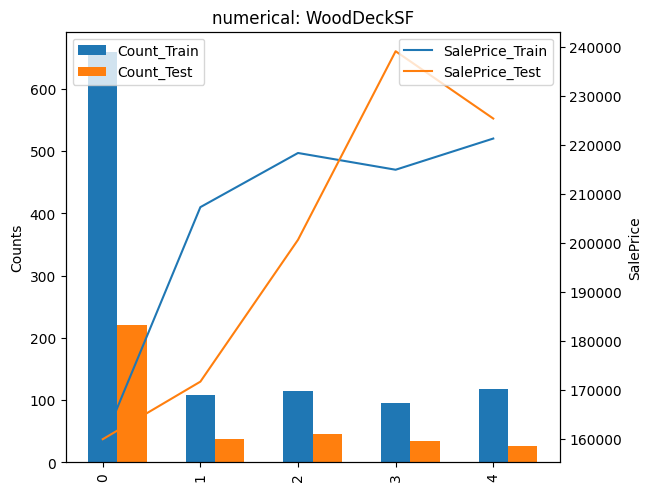

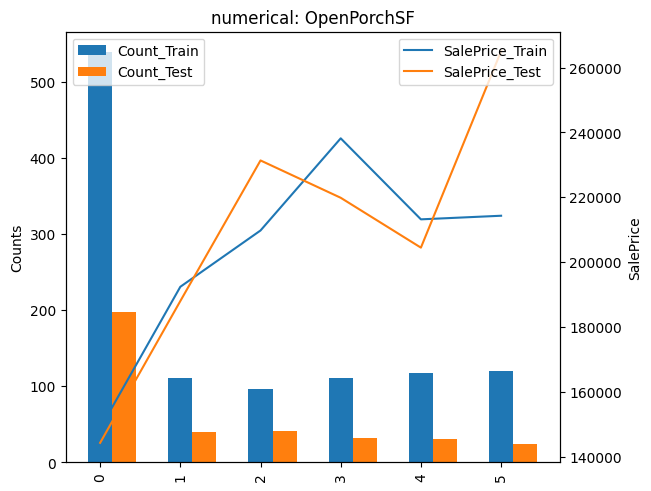

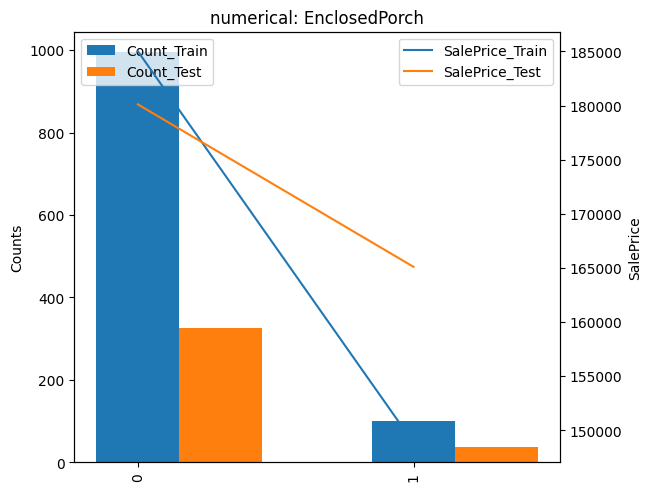

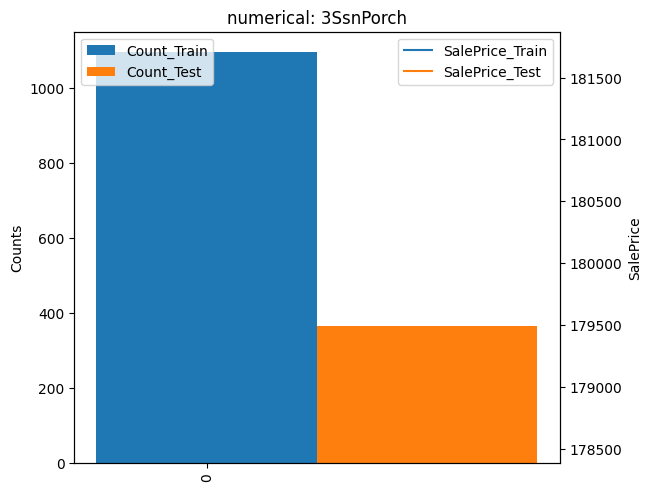

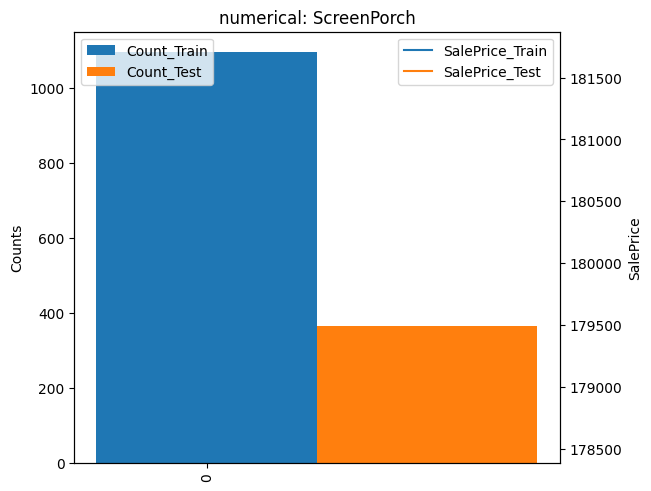

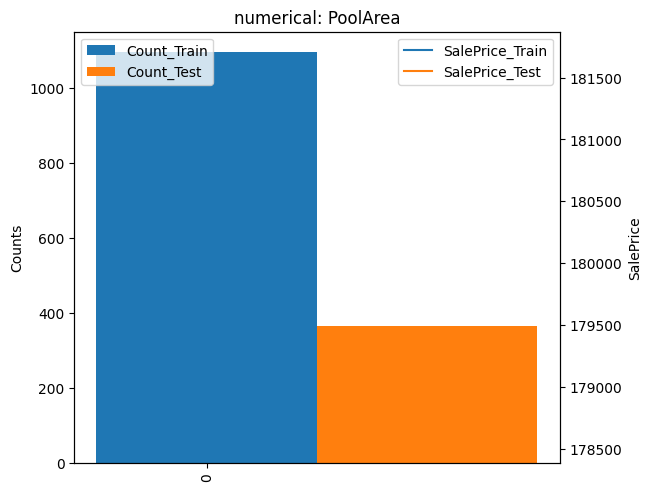

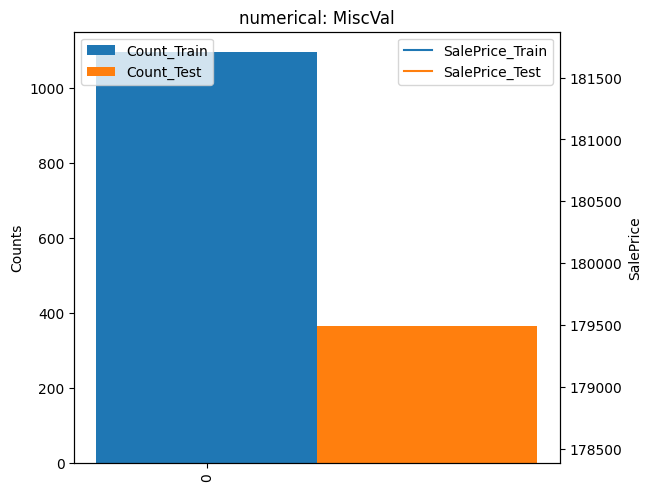

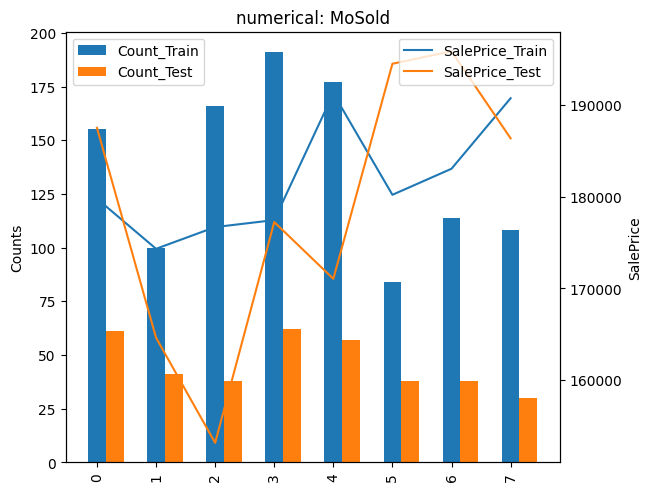

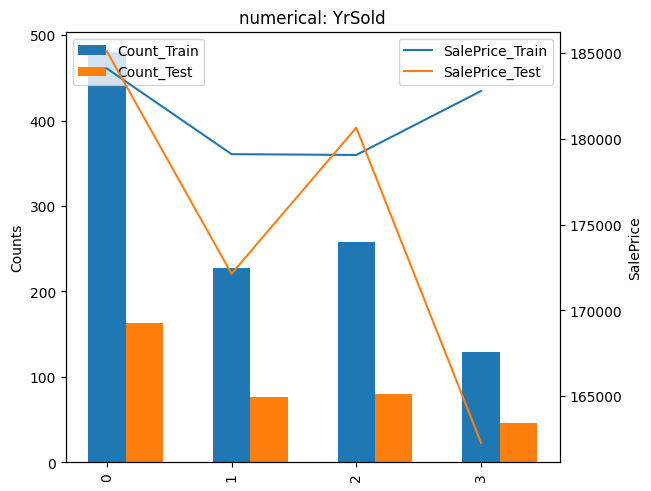

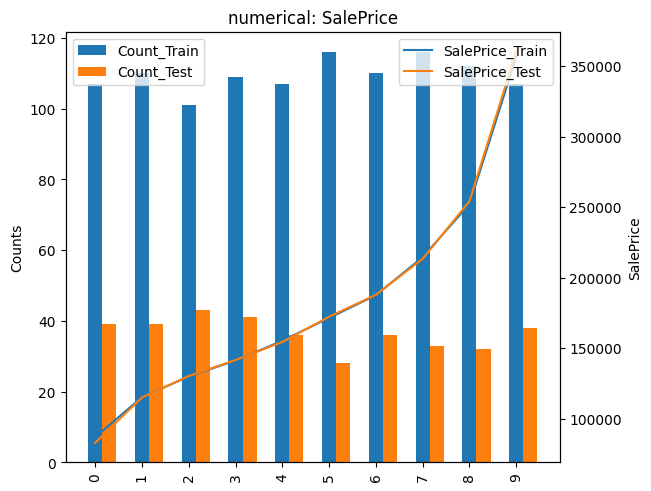

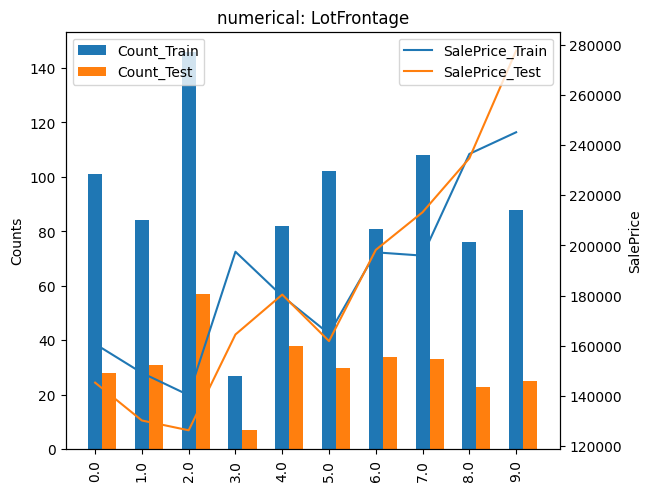

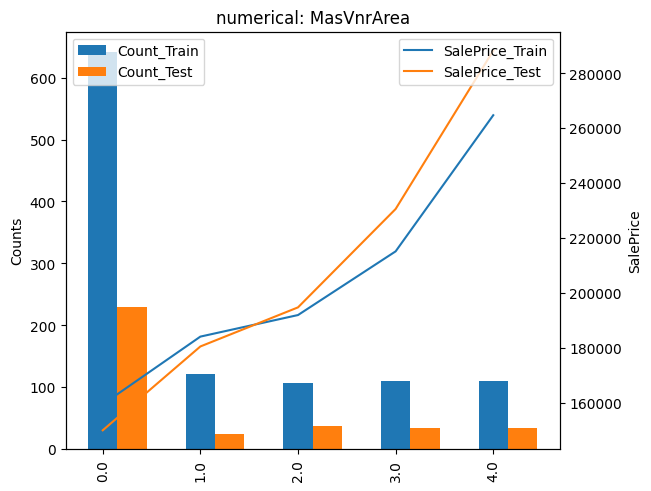

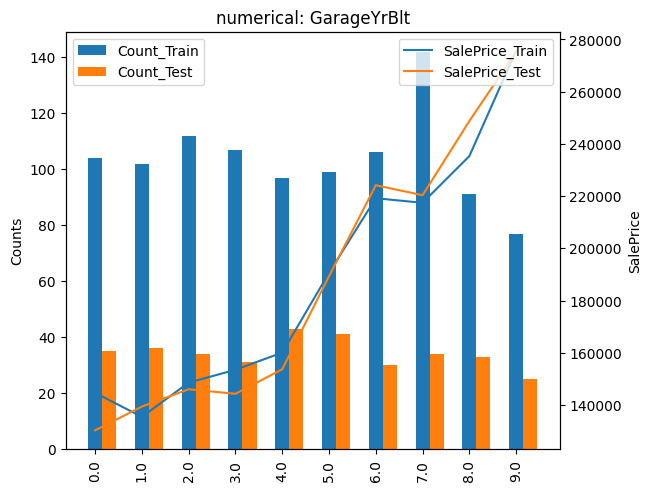

In [23]:
for var in all_variable_list:
    univariate_eda(train_test_data, 'SalePrice', var)

#### Numerical Variables

In [24]:
### Continuous Variable Strategies
    
#def log_transformation(data):
    
#def sqrt_transformation(data):
    


### Data Transformer

In [25]:
X_train = train_data.drop(columns=['SalePrice'])  # Replace 'target_column_name' with your actual target column name
y_train = train_data['SalePrice']

X_test = test_data.drop(columns=['SalePrice'])
y_test = test_data['SalePrice']

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.selected_features]

# Define selected features (numerical and categorical)
numerical_features = ['LotArea','MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                      'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                      'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                      '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

categorical_features = ['KitchenQual', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour','YrSold'] #, 'Utilities', 'LotConfig', 
                        #'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', #'Condition2 - Missing Levels
                        #'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
                        #'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
                        #'CentralAir', 'Electrical', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                        #'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Create pipelines for numerical and categorical preprocessing
numerical_pipeline = Pipeline([
    ('num_selector', FeatureSelector(numerical_features)),
    ('rfe', RFE(estimator=RandomForestRegressor(), n_features_to_select=10)), 
    ('imputer', SimpleImputer(strategy='median')),  # Mean Imputation
    #('scaler', MinMaxScaler()) #StandardScaler())
])

categorical_pipeline = Pipeline([
    ('cat_selector', FeatureSelector(categorical_features)),
    ('encoder', OneHotEncoder())
])

# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Assuming train_data and test_data are defined earlier

# Fit the preprocessor on training data
preprocessor.fit(X_train, y_train)

# Get the selected features from RFE
selected_features = preprocessor.named_transformers_['num'].named_steps['rfe'].get_support(indices=True)

# Print the top 5 selected features
top_10_features = [numerical_features[idx] for idx in selected_features]
print("Top 10 RFE selected features:", top_10_features)

Top 10 RFE selected features: ['LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF']


### Model Pipelines

### Naive Model

In [26]:
# Naive Model


### Linear Models

In [27]:
## Step-Wise

## Tweedie
glm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('glm', LinearRegression())  # Replace with your GLM model
])

## Inverse Gaussian

## Logistic/Binomial

## Multinomial


### Regularization Model Pipelines (Lasso, Ridge, Stochastic Gradient Descent, Elastic Net)

In [28]:
# Lasso Model
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.1, max_iter=1000))
])

# Ridge Model
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1, solver="cholesky", max_iter=1000))
])

# Stochastic Gradient Descent Model
stochastic_gradient_descent_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stochastic_gradient_descent', SGDRegressor(penalty="l2"))
])

# Elastic Net Model
elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1000))
])

### Support Vector Machines

In [29]:
# Support Vector Machine Regression
support_vector_machine_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('support_vector_machine', LinearSVR(epsilon=1.5))
])

### Decision Trees

In [30]:
# Decision Tree Regressor
decision_tree_regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('decision_tree_regressor', DecisionTreeRegressor(max_depth=2))
])

### Random Forest

In [31]:
# Decision Tree Regressor
random_forest_regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest_regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

### Gradient Boosting Machine

In [32]:
# Gradient Boosting Regressor
gradient_boosting_regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gradient_boosting_regressor', GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0))
])

# XGBoost Regressor
xgboost_regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost_regressor', xgboost.XGBRegressor())
])

### Neural Network

## Model Fitting and Evaluation

In [35]:
# Update to add Pipelines
pipelines = [glm_pipeline, lasso_pipeline, ridge_pipeline, stochastic_gradient_descent_pipeline, elastic_net_pipeline,
            support_vector_machine_pipeline, decision_tree_regressor_pipeline, random_forest_regressor_pipeline,
            gradient_boosting_regressor_pipeline, xgboost_regressor_pipeline]

model_types = ['General Linear Model', 'Lasso Model', 'Ridge Model', 'Stochastic Gradient Descent Model', 'Elastic Net Model',
              'Support Vector Machine Model', 'Decision Tree Model', 'Random Forest Model', 'Gradient Boosting Model', 'XGBoost Model']

results = evaluate_pipelines(pipelines, X_train, y_train, X_test, y_test, model_types)

# Print or use results as needed
for result in results:
    print(f"Model Type: {result['model_type']}")
    print(f"R^2 Score: {result['R^2 Score']}")
    print(f"RMSE: {result['RMSE']}")
    print(f"Mean Error: {result['Mean Error']}")
    print(f"Mean Percent Error: {result['Mean Percent Error']}%")
    print("-----------------------------")

General Linear Model Model R^2 Score: 0.8313890732660085
General Linear Model Model Evaluation Metrics:
RMSE: 34368.17788846177
Mean Error: 22227.590622293475
Mean Percent Error: 13.181375822861968%


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.333e+11, tolerance: 6.648e+08
  model = cd_fast.enet_coordinate_descent(


Lasso Model Model R^2 Score: 0.8313974364396275
Lasso Model Model Evaluation Metrics:
RMSE: 34367.32553977823
Mean Error: 22227.091758050337
Mean Percent Error: 13.181157144575131%
Ridge Model Model R^2 Score: 0.8320824565726158
Ridge Model Model Evaluation Metrics:
RMSE: 34297.43849062836
Mean Error: 22189.36670961979
Mean Percent Error: 13.172984844907537%


KeyboardInterrupt: 